In [1]:
import pandas as pd
import numpy as np
from typing import List, Callable
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import stats, shapiro, kstest, mannwhitneyu, norm, probplot, boxcox
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_effectsize
from wordcloud import WordCloud
import re
import pymc as pm
import arviz as az
import datetime
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, mutual_info_classif, RFECV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from catboost import CatBoostRegressor
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
import optuna
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from ab_test_methods import NonParametricMethods_2samp, DeltaAndSampleSize

pd.set_option('display.max_columns', None)

ModuleNotFoundError: No module named 'ab_test_methods'

In [8]:
import pandas as pd
import numpy as np

In [9]:
import pandas as pd
import numpy as np

# Параметры
n_employees = 500
n_rows_per_employee = 1300
probability_of_one = 0.04

# Генерация уникальных имен сотрудников
employee_names = [f"Employee_{i}" for i in range(1, n_employees + 1)]

# Создание пустого списка для хранения данных
data = []

# Генерация данных для каждого сотрудника
np.random.seed(0)  # Для воспроизводимости

for name in employee_names:
    # Генерация бинарных значений с нормальным распределением
    binary_values = np.random.choice([0, 1], size=n_rows_per_employee, p=[0.96, 0.04])

    # Добавление данных в список
    data.extend([(name, value) for value in binary_values])

# Создание DataFrame
df = pd.DataFrame(data, columns=['Employee', 'Binary_Value'])

# Просмотр первых строк DataFrame
print(df.head())


     Employee  Binary_Value
0  Employee_1             0
1  Employee_1             0
2  Employee_1             0
3  Employee_1             0
4  Employee_1             0


In [9]:
num_rows = 50

# Генерируем имена сотрудников (для простоты используем 'Employee_1', 'Employee_2', ...)
employee_names = [f'Employee_{i+1}' for i in range(num_rows)]

# Генерируем общее количество звонков (нормальное распределение)
total_calls = np.random.normal(loc=1300, scale=100, size=num_rows).astype(int)

# Генерируем количество звонков с ошибками (логнормальное распределение)
# Среднее значение - 5% от общего количества звонков
error_calls = np.random.normal(loc=0.04*1300, scale=10, size=num_rows).astype(int)

# Создаем датафрейм
df = pd.DataFrame({
    'Employee': employee_names,
    'Total_Calls': total_calls,
    'Error_Calls': error_calls
})
df

,Employee,Total_Calls,Error_Calls
0,Employee_1,1265,37
1,Employee_2,1377,44
2,Employee_3,1443,36
3,Employee_4,1340,33
4,Employee_5,1360,65
5,Employee_6,1210,64
6,Employee_7,1345,55
7,Employee_8,1334,38
8,Employee_9,1492,40
9,Employee_10,1297,60


In [182]:
# если бы разницы между выборками не было, какова вероятность была бы получить такую разницу
def number_to_binary(total_values, num_ones=None, percent=None):
    if percent is not None:
        num_ones = int(total_values * percent)
    num_zeros = total_values - num_ones
    binary_values = [0] * num_zeros + [1] * num_ones
    np.random.shuffle(binary_values)
    return binary_values

def perm_test(row):
    total_calls = row['Total_Calls']
    error_calls = row['Error_Calls']
    if row['Total_Calls']<200:
        total_calls = 200
        error_calls = int(row['Error_Calls']*(1/(row['Total_Calls']/200)))
    
    a = number_to_binary(total_calls, num_ones=None, percent=0.04)
    b = number_to_binary(total_calls, num_ones=error_calls)

    real_diff = np.mean(a) - np.mean(b)
    combined = np.concatenate([a, b])

    perms = np.array([np.random.permutation(combined) for _ in range(5_000)])
    new_a = perms[:, :len(a)]
    new_b = perms[:, len(a):]

    diffs = np.mean(new_a, axis=1) - np.mean(new_b, axis=1)


    p_value_lower = np.mean(real_diff <= diffs)
    p_value_upper = np.mean(real_diff >= diffs)
    if p_value_upper <= 0.05 :
        x = 'хуже среднего'
    elif p_value_lower <= 0.05:
        x = 'лучше среднего'
    else:
        x = 'соответствует среднему'
    print(p_value_lower, p_value_upper)
    return x

In [208]:
binom.pmf(0.04*400, 400, 0.04)

0.10126259015319179

In [2]:
from scipy.stats import betabinom

In [5]:
betabinom.cdf(cdf, 1328,0.04, 3)

0.000866985432267706

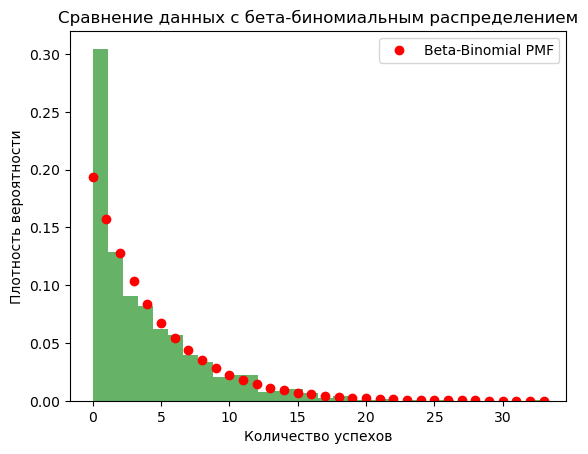

In [227]:
from scipy.stats import betabinom
import seaborn as sns
import matplotlib.pyplot as plt
# Параметры бета-биномиального распределения
n = 100  # общее количество испытаний
a = 1    # параметр альфа бета-распределения
b = 24   # параметр бета бета-распределения (так как средняя вероятность 0.04, b = a * (1/0.04 - 1))

# Генерация данных
data = betabinom.rvs(n, a, b, size=1030)

# Построение гистограммы
plt.hist(data, bins=30, density=True, alpha=0.6, color='g')

# Теоретическое бета-биномиальное распределение
x = np.arange(0, max(data) + 1)
pmf = betabinom.pmf(x, n, a, b)
plt.plot(x, pmf, 'o', color='red', label='Beta-Binomial PMF')

plt.title('Сравнение данных с бета-биномиальным распределением')
plt.xlabel('Количество успехов')
plt.ylabel('Плотность вероятности')
plt.legend()
plt.show()


In [224]:
betabinom.pmf(x, n, a, b)

array([0.19354839, 0.15735641, 0.12769086, 0.10341904, 0.08359706,
       0.06743964, 0.05429463, 0.04362133, 0.03497227, 0.02797782,
       0.02233317, 0.01778748, 0.01413469, 0.01120588, 0.00886283,
       0.0069927 , 0.00550351, 0.00432051, 0.00338304, 0.002642  ,
       0.00205771, 0.00159822, 0.00123784, 0.00095595])

In [230]:
1 * (1/0.04 - 1)

24.0

In [15]:
from scipy.optimize import minimize
data = df['Error_Calls']/df['Total_Calls']  # пример вероятностей ошибок

# Среднее и дисперсия
mu = np.mean(data)
sigma2 = np.var(data)

# Оценка параметров a и b
a = (mu**2 - mu**3 - mu * sigma2) / sigma2
b = a * (1/mu - 1)

a, b

(15.514411558078047, 380.161079843886)

In [16]:
from scipy.optimize import minimize
data = df['Error_Calls'] / df['Total_Calls']

# Среднее и дисперсия
mu = np.mean(data)
sigma2 = np.var(data)

# Оценка параметров a и b (MLE) - ЗАМЕНА СТРОК
def neg_log_likelihood(params, n, k):
    a, b = params
    return -np.sum(betabinom.logpmf(k, n, a, b))

n = df['Total_Calls'].values
k = df['Error_Calls'].values
a_init = (mu**2 - mu**3 - mu * sigma2) / sigma2  # Начальное приближение
b_init = a_init * (1 / mu - 1)
result = minimize(neg_log_likelihood, (a_init, b_init), args=(n, k),
                  method='L-BFGS-B', bounds=[(1e-6, None), (1e-6, None)])
a, b = result.x

In [17]:
a, b

(22.567417752744472, 557.176997349149)

In [10]:
df

,Employee,Total_Calls,Error_Calls
0,Employee_1,1265,37
1,Employee_2,1377,44
2,Employee_3,1443,36
3,Employee_4,1340,33
4,Employee_5,1360,65
5,Employee_6,1210,64
6,Employee_7,1345,55
7,Employee_8,1334,38
8,Employee_9,1492,40
9,Employee_10,1297,60


In [18]:
def prob_test_beta_binomial(row):
    total_calls = row['Total_Calls']
    error_calls = row['Error_Calls']

    # Параметры бета-биномиального распределения
    # a и b выбраны так, чтобы средняя вероятность была 0.04
    a = 22.5    # параметр альфа бета-распределения
    b = a * (1/0.04 - 1)   # параметр бета бета-распределения (так как средняя вероятность 0.04, b = a * (1/0.04 - 1))

    # Рассчитаем вероятность получения такого или меньшего количества ошибок
    prob_lower = betabinom.cdf(error_calls, total_calls, a, b)

    # Рассчитаем вероятность получения такого или большего количества ошибок
    prob_upper = betabinom.sf(error_calls - 1, total_calls, a, b)

    # Определим, как интерпретировать результаты
    if prob_upper <= 0.05:
        result = 'хуже среднего'
    elif prob_lower <= 0.05:
        result = 'лучше среднего'
    else:
        result = 'соответствует среднему'

    print(prob_lower, prob_upper)
    return result

# Пример использования
df.apply(prob_test_beta_binomial, axis=1)

0.1450325322115105 0.8753423497274432
0.22339847258895978 0.8007567897407085
0.051571845431918506 0.9574378041466551
0.04967503162889283 0.9596236808590036
0.8036331490155086 0.21568156479233613
0.902086547910965 0.11075084086794496
0.5770174681900003 0.4523462705205141
0.12264031163947957 0.8949300365986205
0.08099857449759308 0.9311425766658175
0.7611311637338226 0.26172197979626344
0.39912589295826134 0.6292809774528944
0.31563561812691043 0.7140750643518938
0.8787780555908469 0.13640934233724178
0.661263208782813 0.366023063208175
0.11216924709891268 0.9049056568655105
0.30764333133638055 0.7206256370539319
0.031091359115660733 0.9747196907809305
0.7846564418700108 0.23920391082796622
0.5689726988350947 0.4623881616267054
0.9160548517235454 0.09602403616043487
0.7191275743588259 0.30729679258282283
0.5075682861952047 0.5237009521221674
0.631307511574523 0.39789356499448947
0.820768412156559 0.19958209060915988
0.036620464667738356 0.9710231924512459
0.2720894300219536 0.75682347333

0     соответствует среднему
1     соответствует среднему
2     соответствует среднему
3             лучше среднего
4     соответствует среднему
5     соответствует среднему
6     соответствует среднему
7     соответствует среднему
8     соответствует среднему
9     соответствует среднему
10    соответствует среднему
11    соответствует среднему
12    соответствует среднему
13    соответствует среднему
14    соответствует среднему
15    соответствует среднему
16            лучше среднего
17    соответствует среднему
18    соответствует среднему
19    соответствует среднему
20    соответствует среднему
21    соответствует среднему
22    соответствует среднему
23    соответствует среднему
24            лучше среднего
25    соответствует среднему
26    соответствует среднему
27    соответствует среднему
28    соответствует среднему
29    соответствует среднему
30    соответствует среднему
31    соответствует среднему
32    соответствует среднему
33    соответствует среднему
34    соответс

In [222]:
import numpy as np
from scipy.stats import binom

def prob_test(row):
    total_calls = row['Total_Calls']
    error_calls = row['Error_Calls']

    p_error = 0.04

    # Рассчитаем вероятность получения такого или меньшего количества ошибок
    prob_lower = binom.cdf(error_calls, total_calls, p_error)

    # Рассчитаем вероятность получения такого или большего количества ошибок
    prob_upper = binom.sf(error_calls - 1, total_calls, p_error)

    # Определим, как интерпретировать результаты
    if prob_upper <= 0.05:
        result = 'хуже среднего'
    elif prob_lower <= 0.05:
        result = 'лучше среднего'
    else:
        result = 'соответствует среднему'
    print(prob_lower, prob_upper)
    return result

df.apply(prob_test, axis=1)

0.9392987489021118 0.07838114705386592
0.9977804116492186 0.0033177060237561213
0.6309147268106146 0.42498700875683515
3.7136017442555196e-06 0.9999983720017445
0.9297782115343133 0.09061994465172049
0.29878632046847103 0.7514763214964642
0.849144615365567 0.18454898946336679
0.9825399127294513 0.02421718441368803
0.3694380992880829 0.6851212343647507
0.94631308206688 0.07113596861130607
0.8691214746494267 0.16461154768711214
0.08663854388360431 0.9342489359150489
0.02965669663143299 0.9788430970176193
0.9470492662367969 0.07078930524427089
0.9982000256699369 0.0026972631578550048
0.18297938974009798 0.8540248740162562
0.8429098211848727 0.1940168254683031
0.6402089292321735 0.413720633048415
0.8380517448143041 0.19879588763160236
0.8942636154996917 0.13142839973471193
0.017832796639727824 0.9874610699145102
0.692652807872703 0.3563877466788338
0.9999525560240577 7.795442228278066e-05
0.976912884160774 0.03180688478912279
0.5431529242780645 0.5126827169069459
0.8915921713504893 0.13649

0     соответствует среднему
1              хуже среднего
2     соответствует среднему
3             лучше среднего
4     соответствует среднему
5     соответствует среднему
6     соответствует среднему
7              хуже среднего
8     соответствует среднему
9     соответствует среднему
10    соответствует среднему
11    соответствует среднему
12            лучше среднего
13    соответствует среднему
14             хуже среднего
15    соответствует среднему
16    соответствует среднему
17    соответствует среднему
18    соответствует среднему
19    соответствует среднему
20            лучше среднего
21    соответствует среднему
22             хуже среднего
23             хуже среднего
24    соответствует среднему
25    соответствует среднему
26            лучше среднего
27    соответствует среднему
28    соответствует среднему
29             хуже среднего
30    соответствует среднему
31    соответствует среднему
32    соответствует среднему
33    соответствует среднему
34            

In [183]:
%%time
df.apply(perm_test, axis=1)

0.875 0.169
0.9826 0.0272
0.6258 0.4488
0.0 1.0
0.8644 0.182
0.3714 0.7086
0.785 0.2772
0.9416 0.0866
0.4492 0.6306
0.8836 0.1582
0.8096 0.2516
0.1842 0.869
0.0924 0.9374
0.8658 0.1814
0.9816 0.0312
0.2874 0.7858
0.7914 0.2726
0.618 0.4596
0.7968 0.2648
0.8168 0.2382
0.0732 0.9478
0.6834 0.3902
0.9966 0.0072
0.9326 0.0962
0.5706 0.4992
0.8508 0.205
0.018 0.989
0.6684 0.41
0.2074 0.842
0.9766 0.0364
0.2106 0.8474
0.9098 0.1284
0.4224 0.6508
0.64 0.4384
0.1054 0.926
0.8934 0.1484
0.8588 0.1864
0.8728 0.1752
0.9592 0.058
0.205 0.8456
0.2666 0.8036
0.5454 0.5396
0.126 0.9176
0.1138 0.9208
0.2308 0.8282
0.103 0.9278
0.029 0.9812
0.9602 0.0582
0.9934 0.0086
0.8324 0.2186
CPU times: total: 11.9 s
Wall time: 11.8 s


0     соответствует среднему
1              хуже среднего
2     соответствует среднему
3             лучше среднего
4     соответствует среднему
5     соответствует среднему
6     соответствует среднему
7     соответствует среднему
8     соответствует среднему
9     соответствует среднему
10    соответствует среднему
11    соответствует среднему
12    соответствует среднему
13    соответствует среднему
14             хуже среднего
15    соответствует среднему
16    соответствует среднему
17    соответствует среднему
18    соответствует среднему
19    соответствует среднему
20    соответствует среднему
21    соответствует среднему
22             хуже среднего
23    соответствует среднему
24    соответствует среднему
25    соответствует среднему
26            лучше среднего
27    соответствует среднему
28    соответствует среднему
29             хуже среднего
30    соответствует среднему
31    соответствует среднему
32    соответствует среднему
33    соответствует среднему
34    соответс

In [52]:
# Данные: n - число разговоров, k - число разговоров с ошибками (согласно распознаванию)
n = 30      # общее число разговоров
k = 2       # число разговоров, где фиксируется ошибка
p_model = 0.15  # известный процент ложных срабатываний модели

# 1. Вычисляем наблюдаемую пропорцию ошибок
p_obs = k / n

# 2. Строим 95%-й доверительный интервал для p_obs (метод Wilson)
conf_int_obs = proportion_confint(count=k, nobs=n, alpha=0.05, method='wilson')
print("Доверительный интервал для наблюдаемой пропорции ошибок:", conf_int_obs)

# 3. Трансформируем границы интервала для оценки истинной ошибки сотрудника
def adjust_interval(p_obs_bound, p_model):
    # Если наблюдаемая граница меньше p_model, нижняя граница устанавливается в 0
    return max((p_obs_bound - p_model) / (1 - p_model), 0)

lower_true = adjust_interval(conf_int_obs[0], p_model)
upper_true = adjust_interval(conf_int_obs[1], p_model)

print("Оценка истинной вероятности ошибки сотрудника:")
print("Нижняя граница:", lower_true)
print("Верхняя граница:", upper_true)

Доверительный интервал для наблюдаемой пропорции ошибок: (0.018477023791270378, 0.21323458362616926)
Оценка истинной вероятности ошибки сотрудника:
Нижняя граница: 0
Верхняя граница: 0.07439362779549326


In [59]:
import numpy as np
from scipy.stats import beta
n = 30      # общее число разговоров
k = 2       # число разговоров, где зафиксирована ошибка
sensitivity = 0.92  # вероятность, что если ошибка была, модель её зафиксирует

# 1. Корректировка наблюдаемой доли ошибок
p_obs = k / n
p_true_est = p_obs / sensitivity
print(f"Оценка истинного процента ошибок (с корректировкой sensitivity): {p_true_est:.2%}")

# 2. Байесовский подход: задаем априорное распределение
# Если ожидаем, что ошибки редки, можно выбрать, например, Beta(1, 20)
a_prior = 2
b_prior = 20

# Обновляем априорное распределение данными: постериор ~ Beta(k + a_prior, n - k + b_prior)
a_post = k + a_prior
b_post = n - k + b_prior

# Вычисляем 90%-й кредибильный интервал (например, от 5% до 95% квантилей)
lower_cred = beta.ppf(0.1, a_post, b_post)
upper_cred = beta.ppf(0.90, a_post, b_post)
print("90%-й кредибильный интервал для истинного процента ошибок (без учета sensitivity):")
print(f"{lower_cred:.2%} — {upper_cred:.2%}")

# Если хотим скорректировать интервал по sensitivity (так как модель фиксирует ошибку с вероятностью sensitivity)
lower_cred_true = lower_cred / sensitivity
upper_cred_true = upper_cred / sensitivity
print("90%-й кредибильный интервал для истинного процента ошибок (с учетом sensitivity):")
print(f"{lower_cred_true:.2%} — {upper_cred_true:.2%}")

Оценка истинного процента ошибок (с корректировкой sensitivity): 7.25%
90%-й кредибильный интервал для истинного процента ошибок (без учета sensitivity):
3.46% — 12.63%
90%-й кредибильный интервал для истинного процента ошибок (с учетом sensitivity):
3.77% — 13.73%


In [1]:
import numpy as np

# Предположим, что X_fold_train_processed — это матрица с размером (n_samples, n_features)
X_fold_train_processed = np.random.rand(10, 5)  # Пример матрицы

# Предположим, что anomalies — это вектор с размером (n_samples,)
anomalies = np.random.rand(10)  # Пример вектора

# Преобразуем anomalies в матрицу с одной колонкой
anomalies = anomalies[:, np.newaxis]

# Теперь можно объединить массивы
X_fold_train_processed = np.concatenate((X_fold_train_processed, anomalies), axis=1)

In [6]:
anomalies = np.random.rand(10)

In [7]:
anomalies

array([0.74251706, 0.15098852, 0.66725713, 0.82614928, 0.82128769,
       0.05214501, 0.68298205, 0.06065857, 0.73633191, 0.22394557])

In [8]:
anomalies[:, np.newaxis]

array([[0.74251706],
       [0.15098852],
       [0.66725713],
       [0.82614928],
       [0.82128769],
       [0.05214501],
       [0.68298205],
       [0.06065857],
       [0.73633191],
       [0.22394557]])

In [3]:
anomalies

array([[0.24415971],
       [0.93987217],
       [0.88225919],
       [0.07442951],
       [0.95893506],
       [0.20322842],
       [0.47107153],
       [0.8144235 ],
       [0.36611175],
       [0.31824625]])

In [2]:
X_fold_train_processed

array([[0.50180622, 0.44821356, 0.72023512, 0.33606068, 0.2879122 ,
        0.24415971],
       [0.43367867, 0.25192841, 0.69078844, 0.54132776, 0.25365939,
        0.93987217],
       [0.00736229, 0.23515143, 0.02444704, 0.34752507, 0.73620151,
        0.88225919],
       [0.78005292, 0.0627804 , 0.08114493, 0.97153512, 0.66644488,
        0.07442951],
       [0.45987179, 0.19265781, 0.88646088, 0.90590653, 0.59248317,
        0.95893506],
       [0.25192919, 0.01713358, 0.37271049, 0.22855239, 0.06344174,
        0.20322842],
       [0.20808825, 0.29130451, 0.10805175, 0.33138071, 0.54083833,
        0.47107153],
       [0.63588674, 0.47749568, 0.62672087, 0.06724714, 0.73642495,
        0.8144235 ],
       [0.06552815, 0.93017912, 0.49517223, 0.41142207, 0.664666  ,
        0.36611175],
       [0.51512353, 0.28460978, 0.88868524, 0.27846112, 0.92258436,
        0.31824625]])

In [6]:
import pandas as pd

# Пример данных
filtered_df = pd.DataFrame({
    'zero_replaced_A': [1, 2, 3],
    'zero_replaced_B': [4, 5, 6]
})

df15 = pd.DataFrame({
    'column_C': [7, 8, 9],
    'column_D': [10, 11, 12]
})

# Объединение датафреймов по столбцам
result_df = pd.concat([filtered_df, df15], axis=1)

print(result_df)


   zero_replaced_A  zero_replaced_B  column_C  column_D
0                1                4         7        10
1                2                5         8        11
2                3                6         9        12


In [28]:
bins = np.array([0, 10, 20, 30])  # Бины: [0,10), [10,20), [20,30)
data = np.array([-5, 0, 5, 10, 15, 20, 25, 30, 35])

сфе = np.clip(data, 1, 25)
np.digitize(сфе, bins, right=False)


array([1, 1, 1, 2, 2, 3, 3, 3, 3], dtype=int64)

In [ ]:
Ridge()

In [33]:
d = []
d +=['1']

In [34]:
d

['1']

In [20]:
random_values

0.23483715587895235

In [3]:
df.groupby('район')['качество'].mean().to_dict()

{'Восток': 4.5, 'Запад': 6.5, 'Север': 4.5, 'Центр': 5.0, 'Юг': 4.0}

In [2]:
df_test_csv = pd.read_csv('data/test.csv')
df_train_csv = pd.read_csv('data/train.csv')


In [3]:
df_train = df_train_csv.sample(8000, random_state=1)
df_test = df_train_csv.loc[~df_train_csv.index.isin(df_train.index), :]
df_train = df_train.reset_index(drop=True)

In [4]:
df_train.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7995,16454,47,1.0,51.407546,NaN,1.0,10,15.0,2016,0.000070,B,B,46,10309,1,240.0,1,16,B,128912.097870
7996,12247,6,2.0,64.006635,59.067803,1.0,6,25.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,187371.513602
7997,6415,22,1.0,33.184628,22.377444,5.0,6,9.0,1966,0.000995,B,B,42,7651,1,NaN,1,5,B,152657.131003
7998,2744,64,2.0,46.808319,31.305809,6.0,5,9.0,1972,0.002212,B,B,39,7614,3,NaN,1,5,A,231222.942899
7999,15164,69,3.0,81.595189,55.245066,11.0,8,14.0,2003,0.093443,B,B,23,4635,5,3300.0,2,4,B,469353.495788


##### Этот датасет содержит в себе данные для прогнозирования цен на недвижимость. Неизвестно по какому городу эти данные, но выложен он был на Kaggle с описанием на русском языке. Ниже список столбцов:
    Id - идентификационный номер квартиры
    District Id - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [5]:
df_train.info(memory_usage='Deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             8000 non-null   int64  
 1   DistrictId     8000 non-null   int64  
 2   Rooms          8000 non-null   float64
 3   Square         8000 non-null   float64
 4   LifeSquare     6311 non-null   float64
 5   KitchenSquare  8000 non-null   float64
 6   Floor          8000 non-null   int64  
 7   HouseFloor     8000 non-null   float64
 8   HouseYear      8000 non-null   int64  
 9   Ecology_1      8000 non-null   float64
 10  Ecology_2      8000 non-null   object 
 11  Ecology_3      8000 non-null   object 
 12  Social_1       8000 non-null   int64  
 13  Social_2       8000 non-null   int64  
 14  Social_3       8000 non-null   int64  
 15  Healthcare_1   4172 non-null   float64
 16  Helthcare_2    8000 non-null   int64  
 17  Shops_1        8000 non-null   int64  
 18  Shops_2 

### Будем создавать классы, которые так сказать обучим на тренировочных данных, а затем для тестовых уже будем делать трансформацию в пайплайне

#### Изменим типы данных для некоторых столбцов

In [6]:
class TypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, type_mapping):
        self.type_mapping = type_mapping

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col_index, col_type in self.type_mapping.items():
            for n in col_index:
                column_name = X_copy.columns[n]
                X_copy[column_name] = X_copy[column_name].astype(col_type)
        return X_copy

type_transformer = TypeTransformer(type_mapping={(1, 2, 10, 11, 18): 'category',(7,): 'int64'})

df_train_transformed = type_transformer.fit_transform(df_train)

#### Изучим каждый признак подробно

In [7]:
df_train_transformed.describe(include='all')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,8000.000000,8000.0,8000.0,8000.000000,6311.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000,8000,8000,8000.000000,8000.000000,8000.000000,4172.000000,8000.000000,8000.000000,8000,8000.000000
unique,NaN,202.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,NaN,677.0,3101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7922,7777,NaN,NaN,NaN,NaN,NaN,NaN,7332,NaN
mean,8422.925500,NaN,NaN,56.103255,37.452788,6.352250,8.532125,12.546125,4.491289e+03,0.118384,NaN,NaN,24.660625,5337.852375,8.101000,1143.178571,1.322000,4.243250,NaN,213713.170757
std,4846.730637,NaN,NaN,20.378973,95.929011,31.838407,5.237857,6.844686,2.241661e+05,0.118452,NaN,NaN,17.510969,3995.802421,23.903205,1025.546412,1.495692,4.811026,NaN,92463.552289
min,0.000000,NaN,NaN,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,NaN,NaN,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,NaN,59174.778028
25%,4232.500000,NaN,NaN,41.743594,22.767400,1.000000,4.000000,9.000000,1.974000e+03,0.017647,NaN,NaN,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153622.719890
50%,8431.000000,NaN,NaN,52.447761,32.824320,6.000000,7.000000,12.000000,1.977000e+03,0.075424,NaN,NaN,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192072.978769
75%,12613.250000,NaN,NaN,65.765015,45.107755,9.000000,12.000000,17.000000,2.000000e+03,0.195781,NaN,NaN,35.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,248754.385888


#### Взаимодействие целевой переменной и признаков

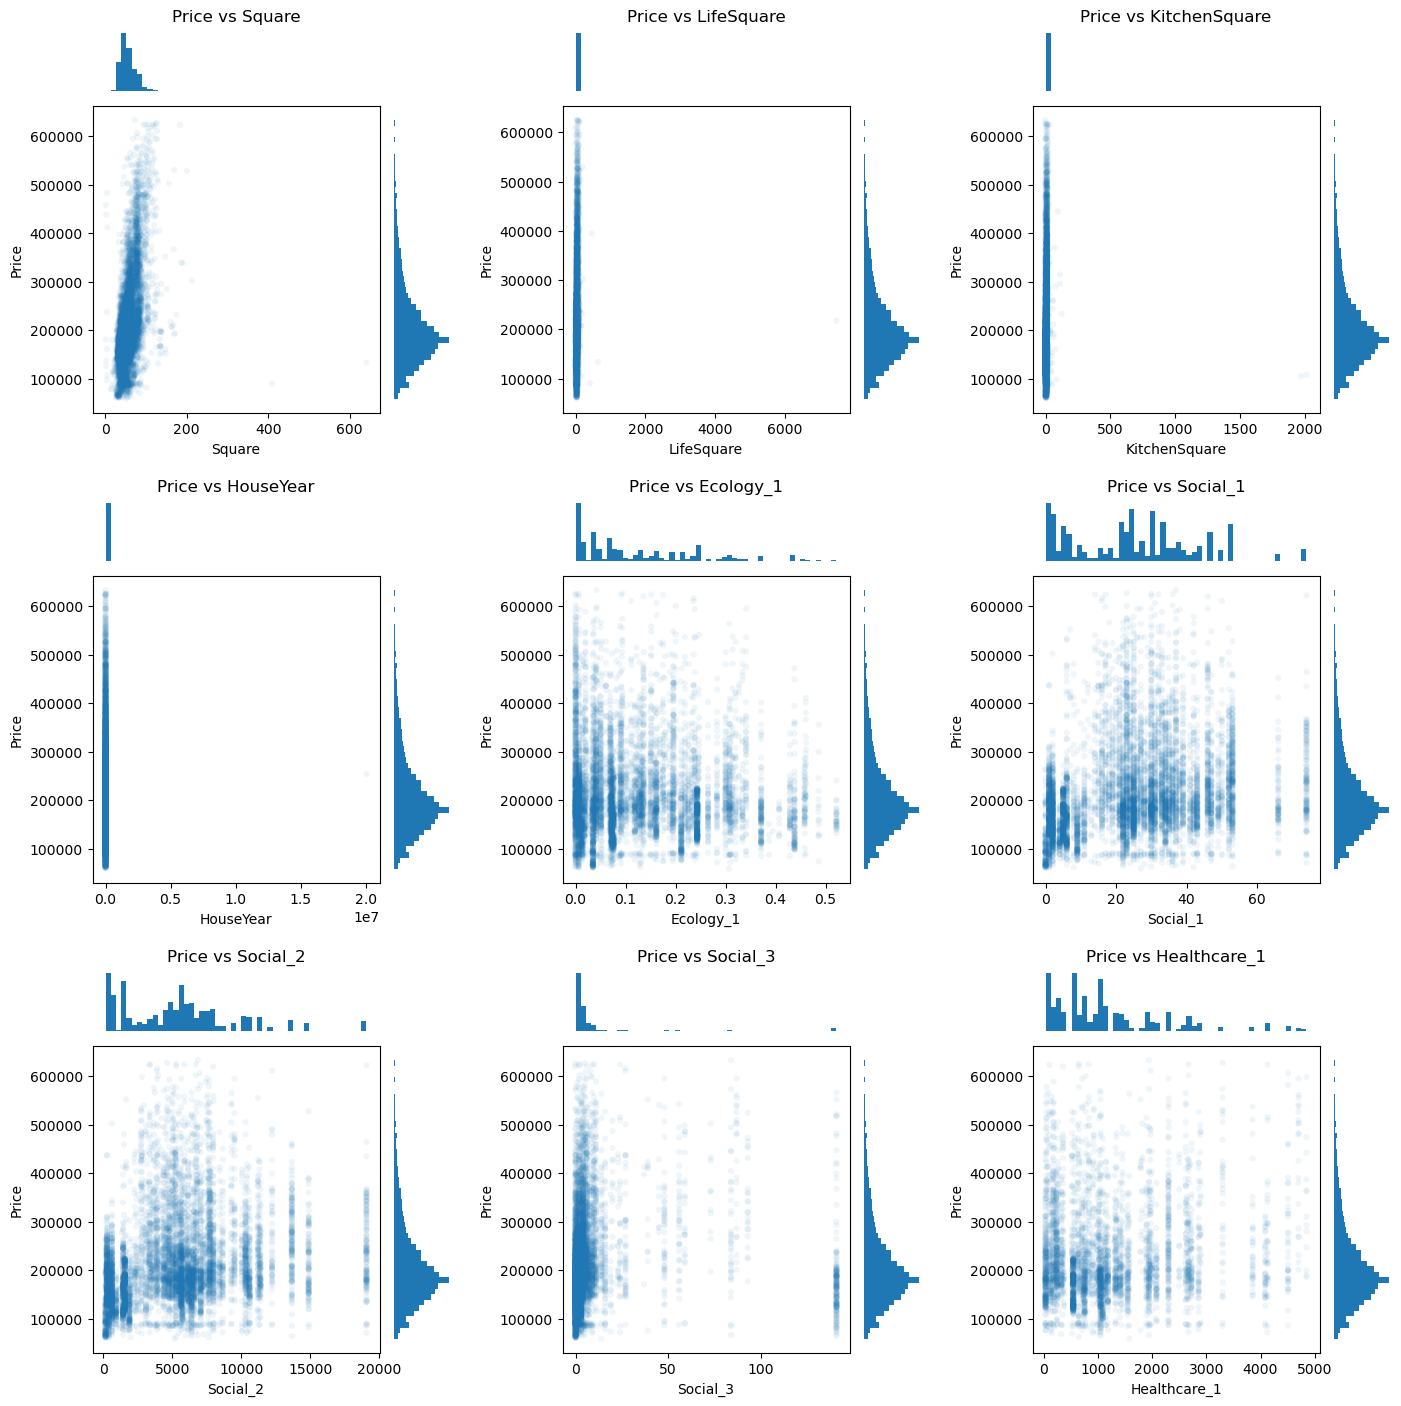

In [8]:
features_1 = ['Square', 'LifeSquare', 'KitchenSquare','HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1']

plt_rows1 = (len(features_1) + 2) // 3
fig, axes = plt.subplots(plt_rows1, 3, figsize=(15, plt_rows1 * 5))
axes = axes.flatten()

for i, feature in enumerate(features_1):
    axes[i].scatter(df_train_transformed[feature], df_train_transformed['Price'], alpha=0.07, s=20, edgecolors='none')
    
    ax_histx = axes[i].inset_axes([0, 1.05, 1, 0.2]) 
    ax_histx.hist(df_train_transformed[feature], bins=50, color=sns.color_palette()[0]) 
    ax_histx.set_axis_off() 

    ax_histy = axes[i].inset_axes([1.05, 0, 0.2, 1])
    ax_histy.hist(df_train_transformed['Price'], bins=50, orientation='horizontal', color=sns.color_palette()[0])
    ax_histy.set_axis_off()

    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')
    axes[i].set_title(f'Price vs {feature}')
    
for j in range(i + 1, len(axes)):  
    fig.delaxes(axes[j])
    
plt.tight_layout(rect=[0,0,0.95,0.95])  
plt.show()

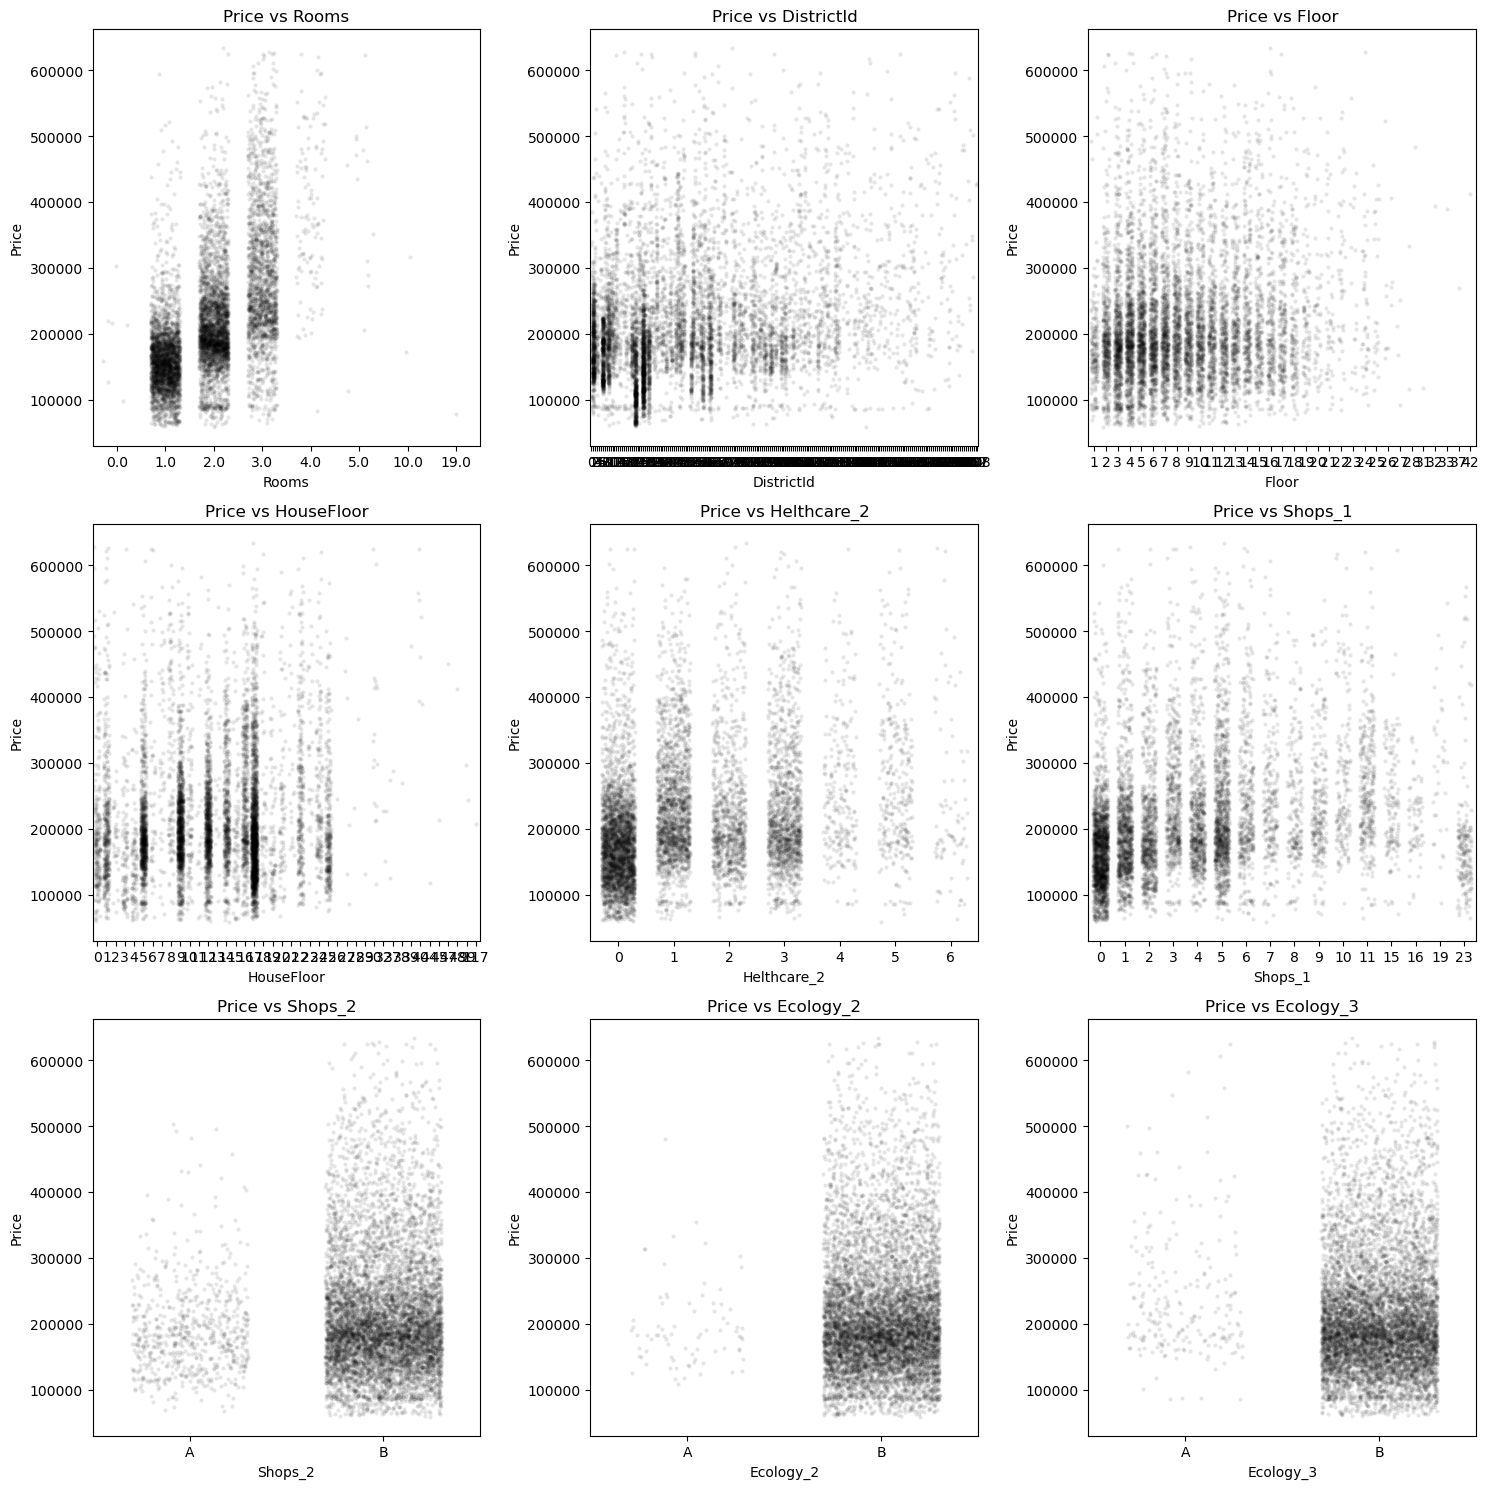

In [9]:
features_2 = ['Rooms', 'DistrictId', 'Floor', 'HouseFloor', 'Helthcare_2', 'Shops_1', 'Shops_2', 'Ecology_2', 'Ecology_3']

plt_rows2 = (len(features_2) + 2) // 3
fig, axes = plt.subplots(plt_rows2, 3, figsize=(15, plt_rows2 * 5))
axes = axes.flatten()

for i, feature in enumerate(features_2):
    sns.stripplot(x=feature, y='Price', data=df_train_transformed, jitter=0.3, color='black', ax=axes[i], alpha=0.1, size=3)
    
    axes[i].set_title(f'Price vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Price')
    
plt.tight_layout() 
plt.show()

#### Сразу видно, что присутствуют некорректные данные. Например жилая площадь 7480 кв метров, при том что максимальная площадь недвижимости равна 640 кв м.
#### Так же есть некорректные данные в столбце с годами постройки дома (20052010 год). И т.к. датасет был выложен в 2020 году, год постройки не может быть больше этого значения, позднее сделаем такое ограничение.
#### Для площади абсолютное большинство значений сконцентрировано в районе до ~230 кв м. И 3-4 значения, которые расположены выше этой границы могут сильно повлиять в негативную сторону на будущее обучение модели. Для задачи предсказания стоимости недвижимости с площадью более 200 кв м лучше реализовать отдельную модель с датасетом, состоящим из большого количества крупных площадей.
#####
#### Проверим сколько недвижимости с площадью меньше 10 кв м и жилой и общей площадью более 200

In [10]:
df_train_transformed[(df_train_transformed['LifeSquare']>200)|(df_train_transformed['Square']>200)|(df_train_transformed['KitchenSquare']>150)|(df_train_transformed['Square']<10)].shape[0]

19

#### При просмотре датафрейма было замечено, что во многих случаях у недвижимости с площадью менее 10 кв м, жилая площадь указана больше общей площади, что невозможно. Так же для такой недвижимости стоимость слишком высока, хотя она должна быть на порядок меньше, чем с классической площадью.

In [11]:
df_train_transformed[(df_train_transformed['HouseYear']>2020)|(df_train_transformed['HouseYear']<1900)].shape[0]

2

#### Случаи, когда жилая площадь больше общей площади

In [12]:
df_train_transformed[df_train_transformed['Square']<df_train_transformed['LifeSquare']].shape[0]

400

#### Случаи, когда кухня больше общей площади

In [13]:
df_train_transformed[df_train_transformed['Square']<df_train_transformed['KitchenSquare']].shape[0]

4

#### Случаи, когда этаж выше количества этажей в доме

In [14]:
df_train_transformed[df_train_transformed['Floor']>df_train_transformed['HouseFloor']].shape[0]

1500

#### Для начала все некорректные значения заменим на NaN, затем будем их заполнять новыми значениями

In [15]:
class OutlierReplacer(BaseEstimator, TransformerMixin):
    """
    Заменяет выбросы в DataFrame на NaN в соответствии с заданными правилами.

    Поддерживаются операции:
    ограничение по минимальному и максимальному значению, ограничение по
    максимальному или минимальному значению, а также сравнение с другим столбцом.

    ВАЖНО!
    --------
        Необходимо выполнять 'need_less_than_other_column' перед остальными случаями.
        Так как если выполнить сначала например 'max_border', то 'need_less_than_other_column'
        будет сравнивать с NaN значениями, результат будет некорректным

    Параметры
    ---------
    outlier_rules : list
        Список словарей, где словари определяют правила замены выбросов.
        Каждое правило должно содержать ключ 'operation', указывающий тип правила и
        ключ 'column', указывающий к какому столбцу применять правило.
        
        Поддерживаемые операции:

        - 'min_max_border':  ограничение `min` и `max`.
            установка NaN для значений меньше min и больше max
        - 'max_border': ограничение по `value`.
            установка NaN для значений больше value
        - 'min_border': ограничение по `value`.
            установка NaN для значений меньше value
        - 'need_less_than_other_column': установка NaN для колонки 'column_to_change',
           если значение в колонке-ключе больше, чем в `other_column`.

    Возвращает
    ----------
    pandas.DataFrame
        Новый DataFrame с замененными на NaN выбросами.

    Пример
    ------
    >>> df = pd.DataFrame({'Square': [5, 50, 150, 250], 'LifeSquare': [2, 60, 300, 190], 'KitchenSquare': [1, 10, 20, 25]})
    >>> outlier_rules = [
             {'column': 'Square', 'operation': 'min_max_border', 'min': 10, 'max': 200},
             {'column': 'LifeSquare', 'operation': 'max_border', 'value': 200},
             {'column': 'LifeSquare', 'operation': 'need_less_than_other_column',
              'other_column': 'Square', 'column_to_change': 'LifeSquare'},
             {'column': 'KitchenSquare', 'operation': 'need_less_than_other_column',
              'other_column': 'Square', 'column_to_change': 'KitchenSquare'}
         ]
    >>> replacer = OutlierReplacer(outlier_rules)
    >>> df_transformed = replacer.fit_transform(df)
    >>> print(df_transformed)
          Square  LifeSquare  KitchenSquare
    0    NaN         2.0              1.0
    1   50.0         NaN             10.0
    2  150.0         NaN             20.0
    3    NaN       190.0             25.0

    """
    def __init__(self, outlier_rules):
        self.outlier_rules = outlier_rules

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()

        for rule in self.outlier_rules:
            column = rule['column']
            if rule['operation'] == 'min_max_border':
                X_copy.loc[(X_copy[column] < rule['min']) | (X_copy[column] > rule['max']), column] = np.NaN
            elif rule['operation'] == 'max_border':
                X_copy.loc[X_copy[column] > rule['value'], column] = np.NaN
            elif rule['operation'] == 'min_border':
                X_copy.loc[X_copy[column] < rule['value'], column] = np.NaN
            elif rule['operation'] == 'need_less_than_other_column':
                X_copy.loc[X_copy[rule['other_column']] < X_copy[rule['column']], rule['column_to_change']] = np.NaN
        return X_copy

#### Сначала посмотрим на boxplot для общей, жилой и кухонной площадей

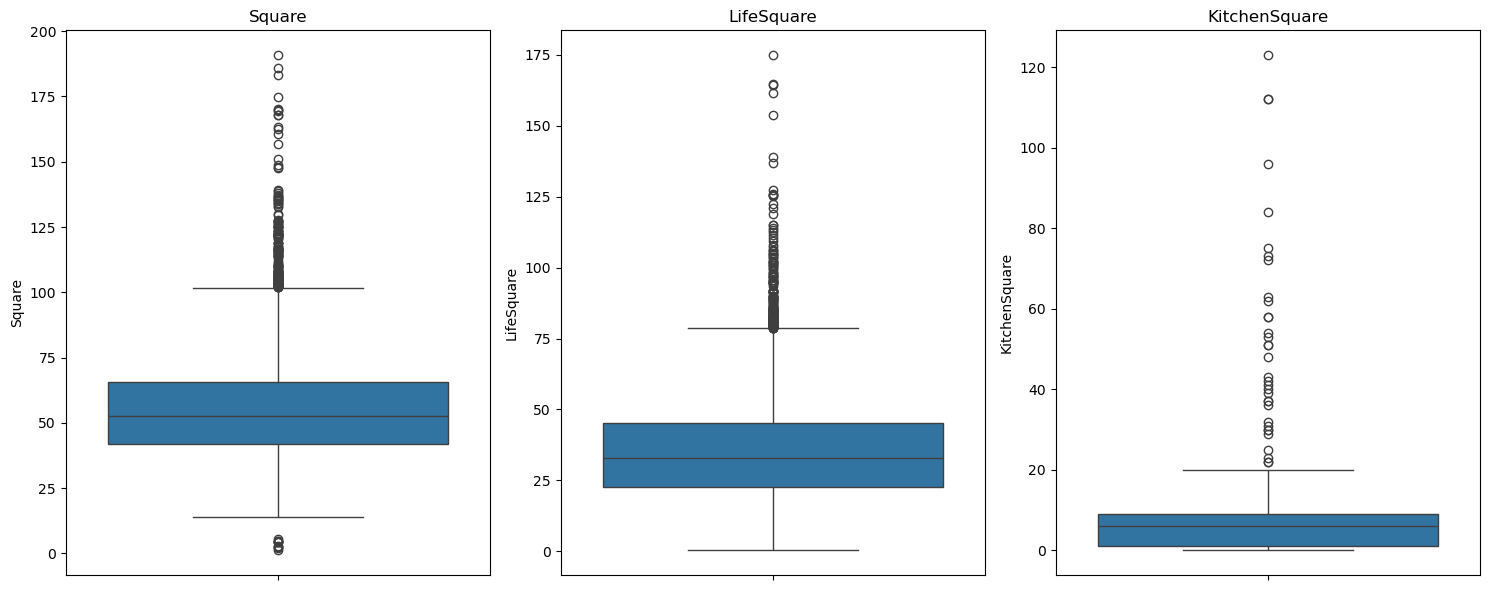

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.boxplot(df_train_transformed['Square'][df_train_transformed['Square']<200], ax=axes[0], whis=1.5)
axes[0].set_title('Square')

sns.boxplot(y=df_train_transformed['LifeSquare'][df_train_transformed['LifeSquare']<200], ax=axes[1], whis=1.5)
axes[1].set_title('LifeSquare')

sns.boxplot(df_train_transformed['KitchenSquare'][df_train_transformed['KitchenSquare']<200], ax=axes[2], whis=1.5)
axes[2].set_title('KitchenSquare')

plt.tight_layout()
plt.show()

##### Из-за скошенного распределения, у нас выбросами считается больше крупных значений, чем малых. Для нижних границ буду использовать boxplot оценку, а для верхних - 99.5 процентиль

In [17]:
top_border_square = df_train_transformed['Square'].quantile(0.995)
top_border_life_square = df_train_transformed['LifeSquare'].quantile(0.995)
top_border_kitchen_square = df_train_transformed['KitchenSquare'].quantile(0.995)
print('Верхняя граница для Square: ',top_border_square)
print('Верхняя граница для LifeSquare: ',top_border_life_square)
print('Верхняя граница для KitchenSquare: ',top_border_kitchen_square)

Верхняя граница для Square:  127.66035616728622
Верхняя граница для LifeSquare:  106.2511772661087
Верхняя граница для KitchenSquare:  20.0


In [18]:

outlier_replacer = OutlierReplacer(outlier_rules=[
    {'column': 'LifeSquare', 'operation': 'need_less_than_other_column', 'other_column': 'Square', 'column_to_change': 'LifeSquare'},
    {'column': 'KitchenSquare', 'operation': 'need_less_than_other_column', 'other_column': 'Square', 'column_to_change': 'KitchenSquare'},
    {'column': 'Square', 'operation': 'min_max_border', 'min': 15, 'max': top_border_square},
    {'column': 'LifeSquare', 'operation': 'max_border', 'value': top_border_life_square},
    {'column': 'KitchenSquare', 'operation': 'max_border', 'value': top_border_kitchen_square},
    {'column': 'HouseYear', 'operation': 'max_border', 'value': 2020}
])
df_train_transformed = outlier_replacer.fit_transform(df_train_transformed)

In [19]:
df_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             8000 non-null   int64   
 1   DistrictId     8000 non-null   category
 2   Rooms          8000 non-null   category
 3   Square         7948 non-null   float64 
 4   LifeSquare     5899 non-null   float64 
 5   KitchenSquare  7964 non-null   float64 
 6   Floor          8000 non-null   int64   
 7   HouseFloor     8000 non-null   int64   
 8   HouseYear      7998 non-null   float64 
 9   Ecology_1      8000 non-null   float64 
 10  Ecology_2      8000 non-null   category
 11  Ecology_3      8000 non-null   category
 12  Social_1       8000 non-null   int64   
 13  Social_2       8000 non-null   int64   
 14  Social_3       8000 non-null   int64   
 15  Healthcare_1   4172 non-null   float64 
 16  Helthcare_2    8000 non-null   int64   
 17  Shops_1        8000 non-null   in

#### Так же отметим строки, где мы заменяли значения на NaN

In [20]:
class NaNFlagTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет флаг-индикатор для NaN значений в указанных столбцах.

    Для каждого указанного столбца создает новый столбец с суффиксом '_was_incorrect',
    который содержит 1, если исходное значение было NaN, и 0 в противном случае.

    Параметры
    ----------
    columns : list
        Список имен столбцов, для которых нужно создать флаги пропусков.

    Возвращает
    -------
    pandas.DataFrame
        Новый DataFrame с добавленными столбцами-флагами.

    """
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in self.columns:
            X_copy[f'{column}_was_incorrect'] = np.where(X_copy[column].isna(), 1, 0)
        return X_copy
        

In [21]:
nan_flag_transformer = NaNFlagTransformer(columns=['LifeSquare', 'Square', 'KitchenSquare', 'HouseYear', 'Healthcare_1'])
df_train_transformed = nan_flag_transformer.fit_transform(df_train_transformed)

## Теперь сделаем импутирование данных. 
##### Изначально я использовал стохастическую импутацию из распределений для square и healthcare_1. А для жилой площади использовал распределение такой формулы: (df_train_transformed['Square'] - df_train_transformed['LifeSquare'])/df_train_transformed['Square']. Для кухни формула соответствующая.
##### Для кухни и площади я случайно выбирал из такого распределения процент, какой общая площадь занимает без жилой площади/кухни. Умножал этот процент на общую площадь и все это отнимал от 1. То есть значения жилой площади и кухни я устанавливал на основе общей площади. 
##### Но постфактум такое импутирование не дало хороших результатов в модели, поэтому я решил использовать более продвинутое решение - IterativeImputer, который использует методы машинного обучения, для импутирования значений.

In [22]:
import warnings
warnings.filterwarnings(
    "ignore", 
    message="'force_all_finite' was renamed to 'ensure_all_finite'", 
    category=FutureWarning
)

In [23]:
class FullImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_columns=['DistrictId', 'Rooms', 'Ecology_2', 'Ecology_3', 'Shops_2']):
        self.cat_columns = cat_columns
        self.cat_encoder = LeaveOneOutEncoder(cols=self.cat_columns, sigma=0.2)
        self.imputer = IterativeImputer(
            estimator=LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=6, min_child_weight=5, reg_alpha=0.1, subsample=0.75, objective='regression_l1', verbosity=-1, n_jobs=-1, random_state=1),
            max_iter=30,             
            initial_strategy='mean', 
            tol=1e-3,
            random_state=1
        )
        self.columns_ = None
        
        self.lifesquare_ratio_mean = None
        self.lifesquare_ratio_std = None
        
    def fit(self, X, y):
        X_copy = X.copy()
        self.columns_ = X_copy.columns
        X_copy_encoded = self.cat_encoder.fit_transform(X_copy, y)
        self.imputer.fit(X_copy_encoded)

        ratio_square_lifesquare = (X_copy['Square'] - X_copy['LifeSquare']) / X_copy['Square']
        self.lifesquare_ratio_mean = ratio_square_lifesquare.mean()
        self.lifesquare_ratio_std = ratio_square_lifesquare.std()
        return self
        
    def transform(self, X):
        X_copy = X.copy()
        
        X_copy_encoded = self.cat_encoder.transform(X_copy)
        
        imputed_array = self.imputer.transform(X_copy_encoded)
        
        imputed_df = pd.DataFrame(imputed_array, columns=self.columns_, index=X_copy.index)
        
        mask = (imputed_df['LifeSquare'] > imputed_df['Square']) | (imputed_df['LifeSquare'] < 0)
        len_incorrect_life_square = imputed_df[mask].shape[0]
        if len_incorrect_life_square>0:
            random_draws = np.random.normal(self.lifesquare_ratio_mean, self.lifesquare_ratio_std, len_incorrect_life_square)
            random_draws = np.where((random_draws <= 0) | (random_draws >= 1), 0.7, random_draws)
            new_life_square = imputed_df.loc[mask, 'Square'] * (1 - random_draws)
            imputed_df.loc[mask, 'LifeSquare'] = new_life_square

        cols_to_replace = ['Square', 'LifeSquare', 'KitchenSquare', 'HouseYear', 'Healthcare_1']

        for col in cols_to_replace:
            X_copy[col] = imputed_df[col]
        
        return X_copy

In [24]:
%%time
full_imputer = FullImputer()
df_train_transformed_1 = full_imputer.fit_transform(df_train_transformed, df_train_transformed['Price'])

CPU times: total: 2min 17s
Wall time: 12.5 s


#### Меняем местами значения столбцов, когда этаж больше этажности дома

In [25]:
class FloorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['Floor_was_incorrect'] = np.where(X_copy['Floor'] > X_copy['HouseFloor'], 1, 0)
        X_copy.loc[X_copy['Floor'] > X_copy['HouseFloor'], ['Floor', 'HouseFloor']] = X_copy.loc[X_copy['Floor'] > X_copy['HouseFloor'], ['HouseFloor', 'Floor']].values
        return X_copy

In [26]:
floor_transformer = FloorTransformer()
df_train_transformed_1 = floor_transformer.fit_transform(df_train_transformed_1)

In [27]:
df_train_transformed_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   Id                           8000 non-null   int64   
 1   DistrictId                   8000 non-null   category
 2   Rooms                        8000 non-null   category
 3   Square                       8000 non-null   float64 
 4   LifeSquare                   8000 non-null   float64 
 5   KitchenSquare                8000 non-null   float64 
 6   Floor                        8000 non-null   int64   
 7   HouseFloor                   8000 non-null   int64   
 8   HouseYear                    8000 non-null   float64 
 9   Ecology_1                    8000 non-null   float64 
 10  Ecology_2                    8000 non-null   category
 11  Ecology_3                    8000 non-null   category
 12  Social_1                     8000 non-null   int64   
 13  Soc

#### Заменим нулевое количество комнат на значение 0.3 (нужно для будущего создания новых признаков). И по графику видно, что случаи с количеством комнат больше 6 почти не встречаются, объединим их в одну категорию

In [28]:
class RoomsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_copy = X.copy()
        
        if 0.3 not in X_copy['Rooms'].cat.categories:
            X_copy['Rooms'] = X_copy['Rooms'].cat.add_categories([0.3])
        if 5.0 not in X_copy['Rooms'].cat.categories:
          X_copy['Rooms'] = X_copy['Rooms'].cat.add_categories([5.0])


        X_copy.loc[X_copy['Rooms'].astype('float64') <= 0, 'Rooms'] = 0.3
        X_copy.loc[X_copy['Rooms'].astype('float64') >= 5, 'Rooms'] = 5.0

        X_copy['Rooms'] = X_copy['Rooms'].cat.remove_unused_categories()
        
        return X_copy
        


In [29]:
rooms_transformer = RoomsTransformer()
df_train_transformed_1 = rooms_transformer.fit_transform(df_train_transformed_1)

#### Теперь пустые и видимые (думаю все еще остается много некорректных, но из-за отсутствия информации о датасете, мы не знаем, что они некорректные) некорректные значения отсутствуют

### Матрица корреляции

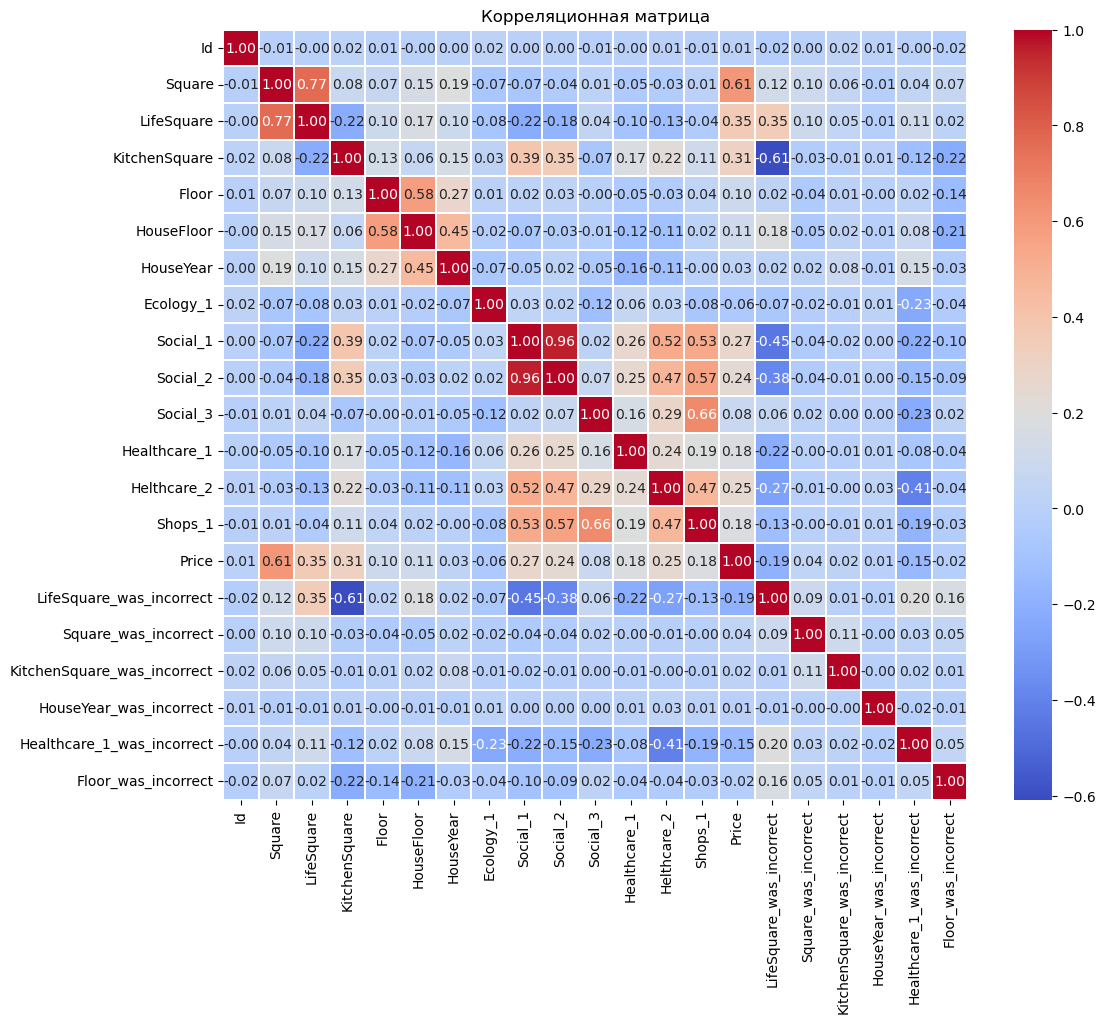

In [30]:
corr_matrix = df_train_transformed_1.select_dtypes(include=['number']).corr()
plt.figure(figsize=(12, 10))


sns.heatmap(corr_matrix, cmap='coolwarm',annot=True,fmt=".2f",linewidths = 0.1)
plt.title('Корреляционная матрица')
plt.show()

#### Интересно то, что добавленные столбцы "**_was_incorrect" имеют относительно высокую отрицательную корреляцию к некоторым другим столбцам.
#### Так как мы не знаем о взятом датасете подробной информации, мы можем лишь гадать о причинах такой корреляции.
####

#### Столбцы Social_1 и Social_2 имеют высокую корреляцию по отношению друг к другу. Это может негативно повлиять на обучение будущей модели
#### Можно было бы удалить один из столбцов. Но мы объединим оба столбца в один, чтоб не потерять информацию

In [31]:
class Social_1_2_Combine(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = RobustScaler()
    def fit(self, X, y=None):
        X_copy = X.copy()
        self.scaler.fit(X_copy[['Social_1', 'Social_2']])
        return self
    def transform(self, X):
        X_copy = X.copy()
        scaled_values = self.scaler.transform(X_copy[['Social_1', 'Social_2']])
        X_copy['Social_1_scaled'] = scaled_values[:, 0]
        X_copy['Social_2_scaled'] = scaled_values[:, 1]
        X_copy['combined_soc1_soc2'] = (X_copy['Social_1_scaled'] + X_copy['Social_2_scaled']) / 2
        X_copy = X_copy.drop(['Social_1', 'Social_2', 'Social_1_scaled', 'Social_2_scaled'], axis=1)
        return X_copy


In [32]:
social_1_2_combine = Social_1_2_Combine()
df_train_transformed_1 = social_1_2_combine.fit_transform(df_train_transformed_1)

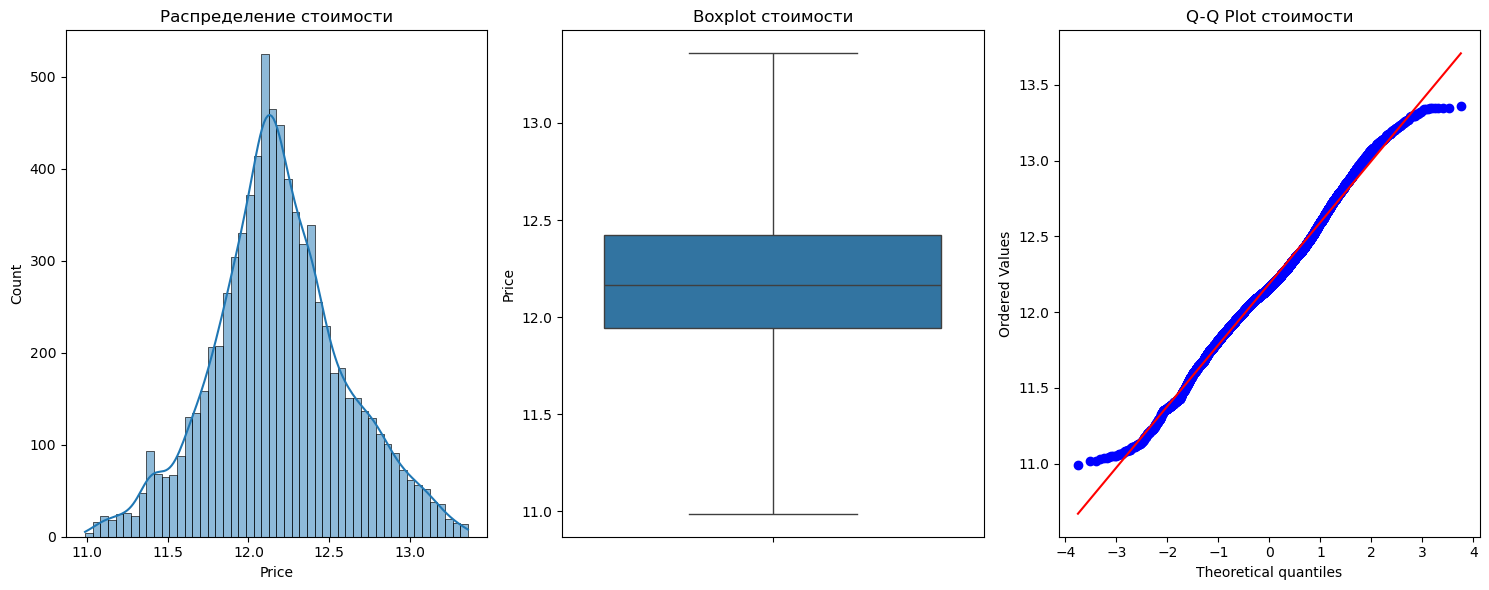

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

sns.histplot(np.log(df_train['Price']), kde=True, bins=50, ax=axes[0])
axes[0].set_title('Распределение стоимости')

sns.boxplot(y=np.log(df_train['Price']), ax=axes[1], whis=3)
axes[1].set_title('Boxplot стоимости')

probplot(np.log(df_train['Price']), dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot стоимости')

plt.tight_layout()
plt.show()

##### Распределение стоимости изначально было сильно скошено. Логарифм исправляет ситуацию

## Создание новых признаков

In [34]:
class NewFeaturesCreate(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.district_counts_ = None

    def fit(self, X, y=None):
        X_copy = X.copy()

        district_counts_series = X_copy['DistrictId'].value_counts(dropna=False)
        
        self.district_counts_ = district_counts_series.to_dict()
        
        return self

    def transform(self, X):
        X_copy = X.copy()

        X_copy['Возраст постройки'] = datetime.date.today().year - X_copy['HouseYear']
        X_copy['Возрастная категория'] = pd.cut(X_copy['Возраст постройки'], bins=[-float('inf'), 10, 30, 50, 70, 100, float('inf')], labels=['новый', 'почти новый', 'средний', 'почти старый', 'старый', 'очень старый'])
        X_copy['Жилая площадь относительно общей'] = X_copy['LifeSquare'] / X_copy['Square']
        X_copy['Площадь кухни относительно общей'] = X_copy['KitchenSquare'] / X_copy['Square']
        X_copy['Относительный этаж'] = X_copy['Floor'] / X_copy['HouseFloor']
        X_copy['Категория этажности дома'] = pd.cut(X_copy['HouseFloor'], bins=[0, 7, 15, 25, 999], labels=['маленький', 'средний', 'большой', 'очень большой'])
        X_copy['Средний размер комнаты'] = X_copy['LifeSquare'] / X_copy['Rooms'].astype('float')
        X_copy['Логарифм общей площади'] = np.log(X_copy['Square']+1)
        X_copy['Логарифм жилой площади'] = np.log(X_copy['LifeSquare']+1)
        X_copy['Логарифм площади кухни'] = np.log(X_copy['KitchenSquare']+1)
        X_copy['Площадь кухни меньше 2'] = (X_copy['KitchenSquare']<2).astype(int)
        X_copy['Жилая площадь занимает больше 95%'] = (X_copy['LifeSquare'] >= 0.95*X_copy['Square']).astype(int)
        X_copy['Остаток площади'] = X_copy['Square'] - X_copy['LifeSquare'] - X_copy['KitchenSquare']
        X_copy['Площадь без жилой'] = X_copy['Square'] - X_copy['LifeSquare']
        X_copy['Площадь без кухни'] = X_copy['Square'] - X_copy['KitchenSquare']
        X_copy['Логарифм combined_soc1_soc2'] = np.log(X_copy['combined_soc1_soc2']+2)
        X_copy['Логарифм Social_3'] = np.log(X_copy['Social_3']+1)
        X_copy['Логарифм Healthcare_1'] = np.log(X_copy['Healthcare_1']+20)
        X_copy['Квадрат combined_soc1_soc2'] = X_copy['combined_soc1_soc2']**2
        X_copy['Квадрат Social_3'] = X_copy['Social_3']**2
        X_copy['Квадрат Shops_1'] = X_copy['Shops_1']**2
        X_copy['Квадрат Healthcare_2'] = X_copy['Helthcare_2']**2
        
        X_copy['Количество строк для района'] = X_copy['DistrictId'].map(self.district_counts_)
        X_copy['Количество строк для района'] = X_copy['Количество строк для района'].fillna(1)
        
        return X_copy

In [35]:
new_features_create = NewFeaturesCreate()
df_train_transformed_2 = new_features_create.fit_transform(df_train_transformed_1)

#### Также надо проверить, совпадает ли набор категорий в train и test (например, test может содержать новый район). Для будущей модели машинного обучения нужно единообразное кодирование

In [36]:
def even_categories_train_test(list_n_column: List[int] | np.ndarray, df_train: pd.DataFrame, df_test: pd.DataFrame):
    for n in list_n_column:
        column_name = df_test.columns[n]
        series_test = df_test[column_name]
        series_train = df_train[column_name]
        count = len(set(series_test.unique()) - set(series_train.unique()))
        print(f'Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца {column_name}:', count)

even_categories_train_test([1, 2, 10, 11, 18], df_train=df_train_transformed, df_test=df_test)

Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца DistrictId: 3
Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца Rooms: 1
Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца Ecology_2: 0
Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца Ecology_3: 0
Количество категорий, которые присутствуют только в df_test, но отсутствуют в df_train для столбца Shops_2: 0


#### В двух столбцах мы имеем в df_test категории, отсутствующие в train
#### При преобразовании категорий в столбцы датафрейма будем использовать Leave One Out Encoder со сглаживанием

In [37]:
encoder = LeaveOneOutEncoder(cols=df_train_transformed_2.columns[[1, 2, 10, 11, 16, 26, 30]], sigma=0.2)

df_train_transformed_3 = encoder.fit_transform(df_train_transformed_2, df_train_transformed_2['Price'])


In [38]:
df_train_transformed_3

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_was_incorrect,Square_was_incorrect,KitchenSquare_was_incorrect,HouseYear_was_incorrect,Healthcare_1_was_incorrect,Floor_was_incorrect,combined_soc1_soc2,Возраст постройки,Возрастная категория,Жилая площадь относительно общей,Площадь кухни относительно общей,Относительный этаж,Категория этажности дома,Средний размер комнаты,Логарифм общей площади,Логарифм жилой площади,Логарифм площади кухни,Площадь кухни меньше 2,Жилая площадь занимает больше 95%,Остаток площади,Площадь без жилой,Площадь без кухни,Логарифм combined_soc1_soc2,Логарифм Social_3,Логарифм Healthcare_1,Квадрат combined_soc1_soc2,Квадрат Social_3,Квадрат Shops_1,Квадрат Healthcare_2,Количество строк для района
0,5365,187030.417789,145961.108786,61.049491,59.836031,0.0,11,17,1977.0,0.007122,244903.375863,172098.213101,0,745.886492,0,1,179062.449390,190085.168584,1,0,0,0,1,0,-0.857109,48.0,223864.510371,0.980123,0.000000,0.647059,215450.857623,29.918015,4.127932,4.108182,0.000000,1,1,1.213461,1.213461,61.049491,0.133561,0.000000,6.641034,0.734636,0,1,0,513
1,3392,190647.611306,157079.866991,55.935924,31.882763,8.0,2,12,1985.0,0.194489,156429.756602,298696.346746,3,125.000000,3,5,240669.166691,197513.930234,0,0,0,0,0,0,0.619377,40.0,217957.743014,0.569987,0.143021,0.166667,223733.515605,15.941382,4.041926,3.492949,2.197225,0,0,16.053160,24.053160,47.935924,0.962937,1.386294,4.976734,0.383628,9,25,9,132
2,1603,160390.385540,314021.975794,90.683040,90.124517,1.0,2,12,1977.0,0.437885,267826.573506,191719.227561,3,1084.000000,0,5,216441.752987,201996.797639,0,0,0,0,0,0,0.005249,48.0,151151.399068,0.993841,0.011027,0.166667,229166.513876,30.041506,4.518337,4.512227,0.693147,1,1,-0.441477,0.558523,89.683040,0.695768,1.386294,7.006695,0.000028,9,25,0,140
3,10063,224346.269534,267779.983369,40.107396,25.747977,7.0,9,10,1971.0,0.210473,184928.235609,242869.440492,2,1994.000000,3,0,227240.007085,211707.020043,0,0,0,0,0,1,-0.496280,54.0,156495.128211,0.641976,0.174531,0.900000,138367.083582,12.873989,3.716188,3.286459,2.079442,0,0,7.359419,14.359419,33.107396,0.407942,1.098612,7.607878,0.246293,4,0,9,9
4,16175,197607.254258,217086.736779,45.026808,29.079454,5.0,5,7,1965.0,0.087619,229174.516031,219433.164522,5,625.096253,1,0,238929.661953,187976.554522,0,0,0,0,1,1,-0.627555,60.0,156180.750482,0.645825,0.111045,0.714286,198991.129626,14.539727,3.829224,3.403842,1.791759,0,0,10.947354,15.947354,40.026808,0.316594,1.791759,6.469400,0.393825,25,0,1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,16454,213010.711757,190366.969096,51.407546,43.866314,1.0,10,15,2016.0,0.000070,210479.624287,216884.684104,1,240.000000,1,16,267113.716303,128912.097870,1,0,0,0,0,0,0.805650,9.0,210687.695630,0.853305,0.019452,0.666667,293620.592345,43.866314,3.959051,3.803687,0.693147,1,0,6.541232,7.541232,50.407546,1.031635,0.693147,5.560682,0.649072,1,256,1,78
7996,12247,182303.224944,274373.863162,64.006635,59.067803,1.0,6,25,1977.0,0.243205,193989.438287,166881.694216,0,540.000000,0,0,148621.280907,187371.513602,0,0,0,0,0,0,-0.673364,48.0,198753.254584,0.922839,0.015623,0.240000,292508.593908,29.533901,4.174489,4.095474,0.693147,1,0,3.938832,4.938832,63.006635,0.282647,0.000000,6.327937,0.453419,0,0,0,404
7997,6415,214851.675930,182292.007497,33.184628,22.377444,5.0,6,9,1966.0,0.000995,281961.636375,226432.846002,1,1122.817215,1,5,229935.784904,152657.131003,0,0,0,0,1,0,0.502003,59.0,210717.565975,0.674332,0.150672,0.666667,133699.029859,22.377444,3.531776,3.151772,1.791759,0,0,5.807184,10.807184,28.184628,0.917092,0.693147,7.041252,0.252007,1,25,1,65
7998,2744,291124.409597,252895.429217,46.808319,31.305809,6.0,5,9,1972.0,0.002212,207121.915469,253118.851379,3,854.874685,1,5,

#### Корреляционная матрица для получившегося датафрейма

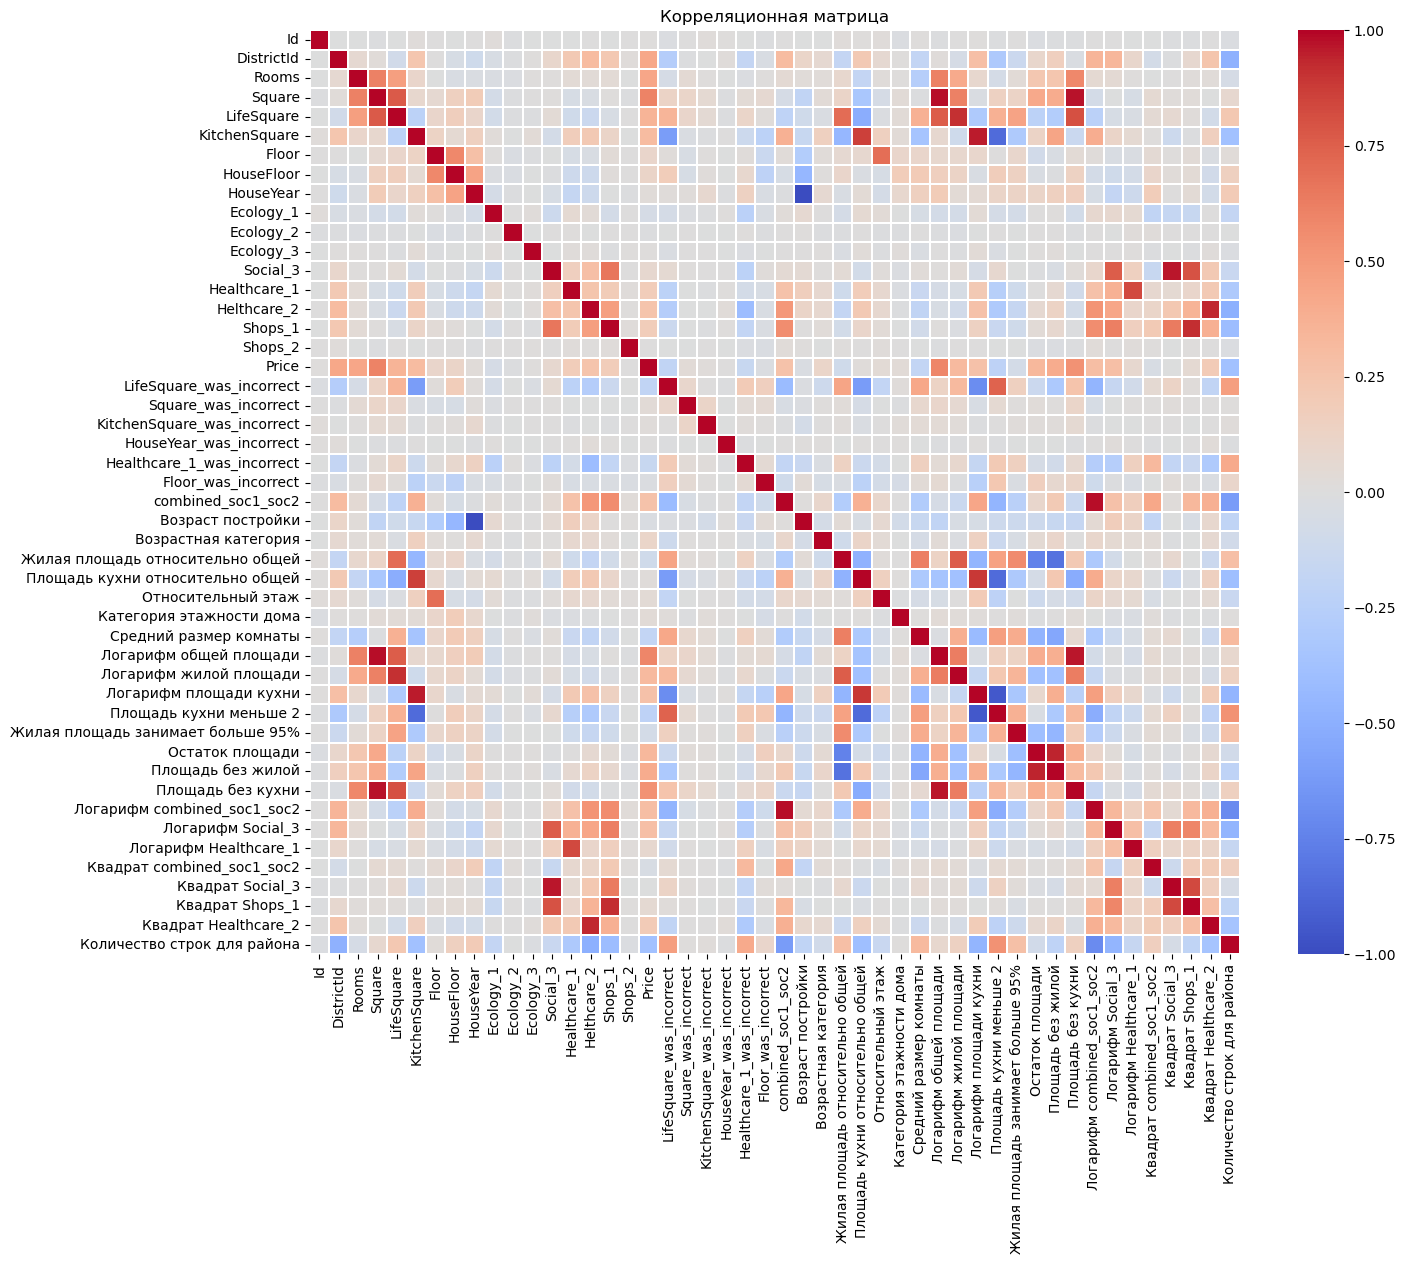

In [39]:
corr_matrix = df_train_transformed_3.select_dtypes(include=['number']).corr()
plt.figure(figsize=(15, 12))


sns.heatmap(corr_matrix, cmap='coolwarm',linewidths = 0.1)
plt.title('Корреляционная матрица')
plt.show()

#### Посмотрим на сильно коррелирующие признаки

In [40]:
def get_correlated_pairs(df, threshold=0.8):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    stacked = upper.stack()
    filtered = stacked[stacked >= threshold]
    return filtered.reset_index().rename(columns={'level_0': 'признак1', 'level_1': 'признак2', 0: 'корреляция'})


correlated_pairs = get_correlated_pairs(df_train_transformed_3, threshold=0.9)
correlated_pairs

,признак1,признак2,корреляция
0,Square,Логарифм общей площади,0.984021
1,Square,Площадь без кухни,0.976038
2,LifeSquare,Логарифм жилой площади,0.908600
3,KitchenSquare,Логарифм площади кухни,0.955548
4,HouseYear,Возраст постройки,1.000000
5,Social_3,Квадрат Social_3,0.967152
6,Helthcare_2,Квадрат Healthcare_2,0.930034
7,Shops_1,Квадрат Shops_1,0.914405
8,combined_soc1_soc2,Логарифм combined_soc1_soc2,0.982297
9,Логарифм общей площади,Площадь без кухни,0.961318


#### 12 признаков сильно коррелируют друг с другом. Оставим из них такие, которые лучше связаны с целевой переменной

In [41]:
high_corr_features = set(correlated_pairs['признак1']) | set(correlated_pairs['признак2'])

In [42]:
def select_features_with_mutual_info(df:pd.DataFrame, y:pd.Series, k='all'):

    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_selected = selector.fit_transform(df, y)

    selected_features = df.columns[selector.get_support()]

    df_selected = pd.DataFrame(X_selected, columns=selected_features)

    mi_scores = pd.Series(selector.scores_, index=df.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return df_selected, selected_features, mi_scores


_, __, mi_scores = select_features_with_mutual_info(df_train_transformed_3[list(high_corr_features)], y=df_train_transformed_3['Price'])
print("Mutual Information оценки:\n", mi_scores)



Mutual Information оценки:
 Square                         0.316554
Логарифм общей площади         0.311407
Логарифм combined_soc1_soc2    0.280337
combined_soc1_soc2             0.277291
Площадь без кухни              0.273003
LifeSquare                     0.221716
Логарифм жилой площади         0.220692
Площадь без жилой              0.187785
Остаток площади                0.144916
Возраст постройки              0.137404
HouseYear                      0.136549
Логарифм площади кухни         0.117427
KitchenSquare                  0.116629
Shops_1                        0.113093
Social_3                       0.112272
Квадрат Shops_1                0.110725
Квадрат Social_3               0.089160
Helthcare_2                    0.079357
Квадрат Healthcare_2           0.078743
Площадь кухни меньше 2         0.046796
dtype: float64


##### Удаляем столбцы "Логарифм общей площади", "Площадь без кухни", "LifeSquare", 'Логарифм площади кухни', "Возраст постройки", "Квадрат Social_3", "Квадрат Healthcare_2", "Квадрат Shops_1", "combined_soc1_soc2", "Остаток площади"

In [43]:
class WithoutHighCorr(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy().drop(["Логарифм общей площади", "Площадь без кухни", "LifeSquare", 'Логарифм площади кухни',
                                "Возраст постройки", "Квадрат Social_3", "Квадрат Healthcare_2", "Квадрат Shops_1", "combined_soc1_soc2", "Остаток площади"], axis=1)
        return X_copy

without_high_corr = WithoutHighCorr()
df_train_transformed_4 = without_high_corr.fit_transform(df_train_transformed_3)

#### Отскалируем признаки и логарифмируем целевую переменную

In [44]:
class TargetLogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        y = X['Price']
        return np.log1p(y)
        
    def inverse_transform(self, y_log):
       return np.expm1(y_log)
        
class FeatureScalerAndDropTarget(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        X_copy = X.copy().drop('Price', axis=1, errors='ignore')
        self.scaler.fit(X_copy)
        return self

    def transform(self, X):
        X_copy = X.copy().drop('Price', axis=1, errors='ignore')
        X_scaled = self.scaler.transform(X_copy)
        X_scaled_df = pd.DataFrame(X_scaled, columns=X_copy.columns, index=X_copy.index)
        return X_scaled_df
    
target_log_transformer = TargetLogTransformer()
y_train_log = target_log_transformer.fit_transform(df_train_transformed_4)
        
feature_scaler_and_drop_target = FeatureScalerAndDropTarget()
X_train_df = feature_scaler_and_drop_target.fit_transform(df_train_transformed_4)


## Удаление признаков по порогу вариации

In [45]:
selector = VarianceThreshold(threshold=0.001) 

X_selected = selector.fit_transform(X_train_df)
selected_features = X_train_df.columns[selector.get_support()]
df_selected = pd.DataFrame(X_selected, columns=selected_features)

print("Исходное количество признаков:", X_train_df.shape[1])
print("Количество отобранных признаков:", df_selected.shape[1])
print("Отобранные признаки:\n", selected_features)


variances = selector.variances_
print("\nДисперсии признаков:")
for feature, variance in zip(X_train_df.columns, variances):
  print(f"{feature}: {variance:.4f}")

Исходное количество признаков: 37
Количество отобранных признаков: 36
Отобранные признаки:
 Index(['Id', 'DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'LifeSquare_was_incorrect', 'Square_was_incorrect',
       'KitchenSquare_was_incorrect', 'Healthcare_1_was_incorrect',
       'Floor_was_incorrect', 'Возрастная категория',
       'Жилая площадь относительно общей', 'Площадь кухни относительно общей',
       'Относительный этаж', 'Категория этажности дома',
       'Средний размер комнаты', 'Логарифм жилой площади',
       'Площадь кухни меньше 2', 'Жилая площадь занимает больше 95%',
       'Площадь без жилой', 'Логарифм combined_soc1_soc2', 'Логарифм Social_3',
       'Логарифм Healthcare_1', 'Квадрат combined_soc1_soc2',
       'Количество строк для района'],
      dtype='object')

Дисперсии признаков:
Id: 0.3344
DistrictI

## Mutual Info

In [46]:
df_selected_m_inf, selected_features_m_inf, mi_scores = select_features_with_mutual_info(df_selected, y=y_train_log, k=31)
print("Выбранные колонки:\n\n", selected_features_m_inf)
print("\nMutual Information оценки:\n", mi_scores)

Выбранные колонки:

 Index(['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Ecology_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'LifeSquare_was_incorrect',
       'Square_was_incorrect', 'Healthcare_1_was_incorrect',
       'Возрастная категория', 'Жилая площадь относительно общей',
       'Площадь кухни относительно общей', 'Относительный этаж',
       'Категория этажности дома', 'Средний размер комнаты',
       'Логарифм жилой площади', 'Площадь кухни меньше 2',
       'Жилая площадь занимает больше 95%', 'Площадь без жилой',
       'Логарифм combined_soc1_soc2', 'Логарифм Social_3',
       'Логарифм Healthcare_1', 'Квадрат combined_soc1_soc2',
       'Количество строк для района'],
      dtype='object')

Mutual Information оценки:
 Square                               0.318108
Логарифм combined_soc1_soc2          0.275311
Площадь кухни относительно общей     0.272279
Количество строк для района          

## Permutation Importance

In [50]:
def cross_val_permutation_importance(X, y, n_repeats):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    all_importances = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = RandomForestRegressor(n_estimators=400, max_depth=7, min_samples_split=12, min_samples_leaf=8, n_jobs=4, random_state=1)
        model.fit(X_train, y_train)

        
        result = permutation_importance(
            estimator=model, 
            X=X_val, 
            y=y_val, 
            scoring='neg_mean_absolute_error', 
            n_repeats=n_repeats, 
            random_state=1
        )
        
        all_importances.append(result.importances_mean)  


    mean_importances = np.mean(all_importances, axis=0)
    feature_names = X.columns

    sorted_idx = np.argsort(mean_importances)[::-1]

    print("Permutation Importance (усреднённая по CV):\n")
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {mean_importances[idx]:.5f}")

    return mean_importances


In [51]:
%%time
mean_importances = cross_val_permutation_importance(df_selected_m_inf, y_train_log, n_repeats=30)

Permutation Importance (усреднённая по CV):

Square: 0.17324
Количество строк для района: 0.09196
Логарифм combined_soc1_soc2: 0.02068
Квадрат combined_soc1_soc2: 0.00975
DistrictId: 0.00756
Ecology_1: 0.00465
Логарифм Social_3: 0.00366
Social_3: 0.00355
HouseFloor: 0.00204
Площадь кухни относительно общей: 0.00139
Средний размер комнаты: 0.00127
Healthcare_1: 0.00073
Площадь без жилой: 0.00073
Логарифм Healthcare_1: 0.00072
Shops_1: 0.00058
HouseYear: 0.00054
Floor: 0.00054
Логарифм жилой площади: 0.00038
KitchenSquare: 0.00032
Helthcare_2: 0.00019
Rooms: 0.00017
Жилая площадь относительно общей: 0.00012
Относительный этаж: 0.00009
Healthcare_1_was_incorrect: 0.00008
Площадь кухни меньше 2: 0.00006
LifeSquare_was_incorrect: 0.00006
Категория этажности дома: 0.00002
Square_was_incorrect: 0.00000
Жилая площадь занимает больше 95%: -0.00000
Возрастная категория: -0.00001
Ecology_2: -0.00002
CPU times: total: 9min 9s
Wall time: 5min 43s


In [106]:
df_important = df_selected_m_inf.loc[:, mean_importances > 0.00005]
print('Количество оставшихся колонок:',df_important.shape[1])

Количество оставшихся колонок: 26


### Проведем Permutation Importance на оставшихся признаках, дабы посмотреть не изменилась ли их важность 

In [53]:
%%time
mean_importances_extra = cross_val_permutation_importance(df_important, y_train_log, n_repeats=10)

Permutation Importance (усреднённая по CV):

Square: 0.17348
Количество строк для района: 0.09202
Логарифм combined_soc1_soc2: 0.02101
Квадрат combined_soc1_soc2: 0.00981
DistrictId: 0.00768
Ecology_1: 0.00470
Логарифм Social_3: 0.00384
Social_3: 0.00367
HouseFloor: 0.00214
Площадь кухни относительно общей: 0.00142
Средний размер комнаты: 0.00125
Логарифм Healthcare_1: 0.00078
Площадь без жилой: 0.00075
Healthcare_1: 0.00073
Shops_1: 0.00062
Floor: 0.00059
HouseYear: 0.00056
Логарифм жилой площади: 0.00040
KitchenSquare: 0.00034
Helthcare_2: 0.00021
Rooms: 0.00020
Относительный этаж: 0.00011
Жилая площадь относительно общей: 0.00010
Площадь кухни меньше 2: 0.00007
Healthcare_1_was_incorrect: 0.00007
LifeSquare_was_incorrect: 0.00007
CPU times: total: 3min 22s
Wall time: 1min 50s


In [54]:
df_important_extra = df_important.loc[:, mean_importances_extra > 0.00005]
print('Количество оставшихся колонок:',df_important_extra.shape[1])

Количество оставшихся колонок: 26


#### Важность почти не изменилась и соответствует нашему условию. Идем дальше.

#### Быстренько на всякий случай проверим для отобранных признаков с помощью Permutation Importance и с помощью Mutual Info результаты на модели без параметров, не стало ли значительно хуже (и стало ли вообще)

In [55]:
def model_test(df, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)  
    
    model = LGBMRegressor()
    
    scores = cross_val_score(
        estimator=model,
        X=df, 
        y=y,
        scoring='neg_mean_squared_error',  
        cv=kf,
        n_jobs=-1 
    )
    
    
    print("Результаты кросс-валидации (neg_mean_squared_error):\n")
    print(scores, '\n')
    print(f"Среднее значение отрицательного MSE: {scores.mean():.5f}")
    print(f"Стандартное отклонение: {scores.std():.5f}")
    
    
    scores_mae = cross_val_score(
        estimator=model,
        X=df,
        y=y,
        scoring='neg_mean_absolute_error',
        cv=kf,
        n_jobs=-1
    )
    
    print("\nРезультаты кросс-валидации (neg_mean_absolute_error):\n")
    print(scores_mae, '\n')
    print(f"Среднее значение отрицательного среднего абсолютного отклонения: {scores_mae.mean():.5f}")
    print(f"Стандартное отклонение: {scores_mae.std():.5f}")


#### Результаты для фич, отобранных Mutual Info

In [56]:
model_test(df_selected_m_inf, y_train_log)

Результаты кросс-валидации (neg_mean_squared_error):

[-0.04655726 -0.04637065 -0.04755865 -0.04986161 -0.04606409] 

Среднее значение отрицательного MSE: -0.04728
Стандартное отклонение: 0.00138

Результаты кросс-валидации (neg_mean_absolute_error):

[-0.13645077 -0.13476332 -0.13556736 -0.13763673 -0.13739525] 

Среднее значение отрицательного среднего абсолютного отклонения: -0.13636
Стандартное отклонение: 0.00109


#### Результаты для фич, отобранных Permutation Importance

In [ ]:
model_test(df_important, y_train_log)

In [128]:
model_test(df_important[['DistrictId', 'Rooms', 'Square', 'Логарифм combined_soc1_soc2','Ecology_1','Social_3','HouseFloor']], y_train_log)

Результаты кросс-валидации (neg_mean_squared_error):

[-0.04927514 -0.05075587 -0.04973578 -0.05174409 -0.05057933] 

Среднее значение отрицательного MSE: -0.05042
Стандартное отклонение: 0.00086

Результаты кросс-валидации (neg_mean_absolute_error):

[-0.14228096 -0.14390142 -0.14170833 -0.14469298 -0.14581235] 

Среднее значение отрицательного среднего абсолютного отклонения: -0.14368
Стандартное отклонение: 0.00151


In [ ]:
Permutation Importance (усреднённая по CV):

Square: 0.17348
Количество строк для района: 0.09202
Логарифм combined_soc1_soc2: 0.02101
Квадрат combined_soc1_soc2: 0.00981
DistrictId: 0.00768
Ecology_1: 0.00470
Логарифм Social_3: 0.00384
Social_3: 0.00367
HouseFloor: 0.00214
Площадь кухни относительно общей: 0.00142
Средний размер комнаты: 0.00125
Логарифм Healthcare_1: 0.00078
Площадь без жилой: 0.00075
Healthcare_1: 0.00073
Shops_1: 0.00062
Floor: 0.00059
HouseYear: 0.00056
Логарифм жилой площади: 0.00040
KitchenSquare: 0.00034
Helthcare_2: 0.00021
Rooms: 0.00020
Относительный этаж: 0.00011
Жилая площадь относительно общей: 0.00010
Площадь кухни меньше 2: 0.00007
Healthcare_1_was_incorrect: 0.00007
LifeSquare_was_incorrect: 0.00007
CPU times: total: 3min 22s
Wall time: 1min 50s

In [117]:
class ImportantColumns(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.pipline_fit_ = 1
        return self

    def transform(self, X):
        X_copy = X.copy()[['DistrictId', 'Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor',
                           'HouseYear', 'Ecology_1', 'Social_3', 'Healthcare_1', 'Helthcare_2',
                           'Shops_1', 'LifeSquare_was_incorrect', 'Healthcare_1_was_incorrect',
                           'Жилая площадь относительно общей', 'Площадь кухни относительно общей',
                           'Относительный этаж', 'Средний размер комнаты',
                           'Логарифм жилой площади', 'Площадь кухни меньше 2', 'Площадь без жилой',
                           'Логарифм combined_soc1_soc2', 'Логарифм Social_3',
                           'Логарифм Healthcare_1', 'Квадрат combined_soc1_soc2',
                           'Количество строк для района']]
        return X_copy
        

In [118]:
pipeline = Pipeline([
    ('type_transformer', TypeTransformer(type_mapping={(1, 2, 10, 11, 18): 'category',(7,): 'int64'})),
    ('outlier_replaces', OutlierReplacer(outlier_rules=[
        {'column': 'LifeSquare', 'operation': 'need_less_than_other_column', 'other_column': 'Square', 'column_to_change': 'LifeSquare'},
        {'column': 'KitchenSquare', 'operation': 'need_less_than_other_column', 'other_column': 'Square', 'column_to_change': 'KitchenSquare'},
        {'column': 'Square', 'operation': 'min_max_border', 'min': 15, 'max': 127.660},
        {'column': 'LifeSquare', 'operation': 'max_border', 'value': 106.251},
        {'column': 'KitchenSquare', 'operation': 'max_border', 'value': 20},
        {'column': 'HouseYear', 'operation': 'max_border', 'value': 2020}
    ])),
    ('nan_flag_transformer', NaNFlagTransformer(columns=['LifeSquare', 'Square', 'KitchenSquare', 'HouseYear', 'Healthcare_1'])),
    ('full_imputer', FullImputer()),
    ('floor_transformer', FloorTransformer()),
    ('rooms_transformer', RoomsTransformer()),
    ('social_1_2_combine', Social_1_2_Combine()),
    ('new_features_create', NewFeaturesCreate()),
    ('encoder', LeaveOneOutEncoder(cols=['DistrictId', 'Rooms', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Возрастная категория', 'Категория этажности дома'], sigma=0.1)),
    ('without_high_corr', WithoutHighCorr()),
    ('feature_scaler_and_drop_target', FeatureScalerAndDropTarget()),
    ('important_columns', ImportantColumns())
])

In [119]:
%%time
pipeline.fit(df_train, df_train['Price'])
df_train_piplined = pipeline.transform(df_train)

CPU times: total: 1min 36s
Wall time: 9.28 s


In [120]:
df_test_piplined = pipeline.transform(df_test)
df_test_piplined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 0 to 9995
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DistrictId                        2000 non-null   float64
 1   Rooms                             2000 non-null   float64
 2   Square                            2000 non-null   float64
 3   KitchenSquare                     2000 non-null   float64
 4   Floor                             2000 non-null   float64
 5   HouseFloor                        2000 non-null   float64
 6   HouseYear                         2000 non-null   float64
 7   Ecology_1                         2000 non-null   float64
 8   Social_3                          2000 non-null   float64
 9   Healthcare_1                      2000 non-null   float64
 10  Helthcare_2                       2000 non-null   float64
 11  Shops_1                           2000 non-null   float64
 12  LifeSquare_

In [121]:
target_log_transformer = TargetLogTransformer()
y_train_log = target_log_transformer.fit_transform(df_train)
y_test_log = target_log_transformer.fit_transform(df_test)

#### Показатели с отбором с помощью Permutation Importance улучшились. Берем его (даже если бы слегка ухудшились, все равно бы оставили его)

### С помощью optuna протестируем 5 моделей, выберем лучшую из них с лучшими гиперпараметрами

In [125]:
def objective(trial):
    model_name = trial.suggest_categorical("model", ["LGBM", "XGBoost", "RandomForest", "KernelRidge", "KNN", "ElasticNet"])

    if model_name == "LGBM":
        n_estimators = trial.suggest_int("lgbm_n_estimators", 200, 800, step=50)
        learning_rate = trial.suggest_float("lgbm_learning_rate", 0.01, 0.15, log=True)  
        num_leaves = trial.suggest_int("lgbm_num_leaves", 20, 60, step=10) 
        max_depth = trial.suggest_int("lgbm_max_depth", 3, 7)   
        min_child_samples = trial.suggest_int("lgbm_min_child_samples", 20, 50, step=3) 
        subsample = trial.suggest_float("lgbm_subsample", 0.4, 1.0)
        colsample_bytree = trial.suggest_float("lgbm_colsample_bytree", 0.5, 1.0) 
        reg_alpha = trial.suggest_float("lgbm_reg_alpha", 1e-2, 10.0, log=True) 
        reg_lambda = trial.suggest_float("lgbm_reg_lambda", 1e-2, 10.0, log=True)
        objective = trial.suggest_categorical("lgbm_objective", ["regression_l1", "regression", "fair"])
        metric = "mae"
        boosting_type = trial.suggest_categorical("lgbm_boosting_type", ["gbdt", "dart", "goss"])
    
        model = LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            num_leaves=num_leaves,
            max_depth=max_depth,
            min_child_samples=min_child_samples, 
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            objective=objective,
            metric = metric,
            boosting_type = boosting_type,
            random_state=1,
            n_jobs=4,
            verbosity=-1,
        )

    elif model_name == "XGBoost":
        booster = trial.suggest_categorical("xgb_booster", ["gbtree", "dart"])
        n_estimators = trial.suggest_int("xgb_n_estimators", 200, 800, step=50)  
        learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.15, log=True) 
        max_depth = trial.suggest_int("xgb_max_depth", 3, 7)
        min_child_weight = trial.suggest_int("xgb_min_child_weight", 3, 10)
        subsample = trial.suggest_float("xgb_subsample", 0.4, 1.0)
        colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.4, 1.0)
        gamma = trial.suggest_float("xgb_gamma", 0, 1.0)
        reg_alpha = trial.suggest_float("xgb_reg_alpha", 1e-1, 10.0, log=True) 
        reg_lambda = trial.suggest_float("xgb_reg_lambda", 1e-1, 10.0, log=True) 
    
        model = XGBRegressor(
            booster = booster,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=1,
            n_jobs=4,
        )
    elif model_name == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 100, 500, step=50) 
        max_depth = trial.suggest_int("rf_max_depth", 3, 8)  
        min_samples_split = trial.suggest_int("rf_min_samples_split", 5, 20)
        min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 3, 10)

    
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=1,
            n_jobs=4,
        )

    elif model_name == "KernelRidge":
        alpha = trial.suggest_float("kr_alpha", 1e-1, 10, log=True)
        kernel = trial.suggest_categorical("kr_kernel", ["rbf", "poly", "sigmoid", "linear"])

        
        if kernel == "rbf":
            gamma = trial.suggest_float("kr_gamma", 1e-2, 10, log=True)
            model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma) 
        elif kernel == "poly":
            gamma = trial.suggest_float("kr_gamma", 1e-2, 10, log=True)
            degree = trial.suggest_int("kr_degree", 2, 4)
            coef0 = trial.suggest_float("kr_coef0", -1.0, 1.0)
            model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma, degree=degree, coef0=coef0) 
        elif kernel == "sigmoid":
            gamma = trial.suggest_float("kr_gamma", 1e-2, 10, log=True)
            coef0 = trial.suggest_float("kr_coef0", 0, 1.0)
            model = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma, coef0=coef0)
        elif kernel == "linear":
            model = KernelRidge(alpha=alpha, kernel=kernel)


          
    elif model_name == "KNN":
        n_neighbors = trial.suggest_int("knn_n_neighbors", 5, 50)
        weights = trial.suggest_categorical("knn_weights", ["uniform", "distance"])
        p = trial.suggest_int("knn_p", 1, 3)
        model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p, n_jobs=4)

    elif model_name == "ElasticNet":
        alpha = trial.suggest_float('en_alpha', 1e-1, 100.0, log=True)
        l1_ratio = trial.suggest_float('en_l1_ratio', 0.1, 1.0)
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=1, max_iter=10000)

    
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    
    scores = cross_val_score(
        model,
        df_important.values,
        y_train_log.values,
        cv=kf,
        scoring="neg_mean_squared_error",
        n_jobs=4,
    )
    return scores.mean()

In [113]:
%%time
study = optuna.create_study(direction="maximize")

trials_data = []

def callback(study, trial):
    trials_data.append({
        'trial_number': trial.number,
        'value': trial.value,
        'params': trial.params,
        'datetime_start': trial.datetime_start,
        'datetime_complete': trial.datetime_complete,
    })

study.optimize(objective, n_trials=50, callbacks=[callback])

trials_df = pd.DataFrame(trials_data)
trials_df = pd.concat([trials_df.drop(['params'], axis=1), trials_df['params'].apply(pd.Series)], axis=1)

print("\nЛучшая попытка:")
print(f"  Оценка: {study.best_value}")
print(f"  Параметры: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

[I 2025-02-19 20:14:44,657] A new study created in memory with name: no-name-d20d09c1-4ab8-4084-b9df-1ccd1ea92b60
[I 2025-02-19 20:14:50,655] Trial 0 finished with value: -0.06292589893431275 and parameters: {'model': 'KNN', 'knn_n_neighbors': 28, 'knn_weights': 'distance', 'knn_p': 3}. Best is trial 0 with value: -0.06292589893431275.
[I 2025-02-19 20:17:36,207] Trial 1 finished with value: -2.076428806900645 and parameters: {'model': 'KernelRidge', 'kr_alpha': 1.2490575966543638, 'kr_kernel': 'rbf', 'kr_gamma': 0.13036805186521733}. Best is trial 0 with value: -0.06292589893431275.
[I 2025-02-19 20:17:37,688] Trial 2 finished with value: -0.047438447138492164 and parameters: {'model': 'XGBoost', 'xgb_booster': 'gbtree', 'xgb_n_estimators': 400, 'xgb_learning_rate': 0.03787604772291038, 'xgb_max_depth': 5, 'xgb_min_child_weight': 5, 'xgb_subsample': 0.4952820714236871, 'xgb_colsample_bytree': 0.6971501920998244, 'xgb_gamma': 0.2766942767803634, 'xgb_reg_alpha': 0.866659178368928, 'xgb


Лучшая попытка:
  Оценка: -0.04592031762325739
  Параметры: 
    model: LGBM
    lgbm_n_estimators: 250
    lgbm_learning_rate: 0.10684261407290292
    lgbm_num_leaves: 30
    lgbm_max_depth: 8
    lgbm_min_child_samples: 38
    lgbm_subsample: 0.5796078465049845
    lgbm_colsample_bytree: 0.9161675109736451
    lgbm_reg_alpha: 3.8702518721507313
    lgbm_reg_lambda: 4.4407599169804275
    lgbm_objective: regression_l1
    lgbm_metric: mae
    lgbm_boosting_type: gbdt
CPU times: total: 11.5 s
Wall time: 37min 28s


In [114]:
model_prefixes = {'XGBoost':'xgb_', 'RandomForest':'rf_', 'LGBM':'lgbm_', 'KernelRidge':'kr_', 'KNN':'knn_',"ElasticNet":'en_'}

list_trial_dfs = []
for k, value in model_prefixes.items():
    df_to_append = trials_df[trials_df['model']==k].rename(columns=lambda x: x.replace(value, ''))
    for prefix in list(set(model_prefixes.values()) ^ set({value})):
        regex_=f'^(?!{prefix}).*'
        df_to_append = df_to_append.filter(regex=regex_)
    list_trial_dfs.append(df_to_append)
trials_df_formatted = pd.concat(list_trial_dfs, axis=0)
trials_df_formatted.sort_values(by='value').tail(5)

,trial_number,value,datetime_start,datetime_complete,model,booster,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_samples_split,min_samples_leaf,num_leaves,min_child_samples,objective,metric,boosting_type,alpha,kernel,coef0,n_neighbors,weights,p,l1_ratio
42,42,-0.046106,2025-02-19 20:51:58.831584,2025-02-19 20:52:00.756415,LGBM,NaN,250.0,0.103755,8.0,NaN,0.552458,0.964419,NaN,3.308478,3.794741,NaN,NaN,30.0,26.0,regression_l1,mae,gbdt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,49,-0.046088,2025-02-19 20:52:11.635405,2025-02-19 20:52:13.063753,LGBM,NaN,200.0,0.117788,7.0,NaN,0.480196,0.902976,NaN,2.217157,1.510561,NaN,NaN,30.0,38.0,regression_l1,mae,gbdt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,44,-0.046064,2025-02-19 20:52:02.706804,2025-02-19 20:52:04.605947,LGBM,NaN,250.0,0.110944,8.0,NaN,0.575978,0.914709,NaN,3.852122,4.297318,NaN,NaN,30.0,38.0,regression_l1,mae,gbdt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,39,-0.045967,2025-02-19 20:51:26.458686,2025-02-19 20:51:28.960463,LGBM,NaN,300.0,0.109871,8.0,NaN,0.584891,0.915623,NaN,3.822087,3.941443,NaN,NaN,40.0,26.0,regression_l1,mae,gbdt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,46,-0.045920,2025-02-19 20:52:06.462022,2025-02-19 20:52:08.309260,LGBM,NaN,250.0,0.106843,8.0,NaN,0.579608,0.916168,NaN,3.870252,4.440760,NaN,NaN,30.0,38.0,regression_l1,mae,gbdt,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
trials_df_formatted.to_csv('trials_df.csv')

In [116]:
best_params = study.best_params
best_model_name = best_params.pop('model')

prefix = model_prefixes[best_model_name]
best_params_without_prefix = {k.replace(prefix, ""): value for k, value in best_params.items() if k.startswith(prefix)}

if best_model_name == 'LGBM':
    best_model = LGBMRegressor(**best_params_without_prefix, random_state=1, n_jobs=4, verbosity=-1)
elif best_model_name == 'XGBoost':
    best_model = XGBRegressor(**best_params_without_prefix, random_state=1, n_jobs=4)
elif best_model_name == 'RandomForest':
    best_model = RandomForestRegressor(**best_params_without_prefix, random_state=1, n_jobs=4)
elif best_model_name == 'KernelRidge':
    best_model = KernelRidge(**best_params_without_prefix)
elif best_model_name == 'KNN':
    best_model = KNeighborsRegressor(**best_params_without_prefix, n_jobs=4)
elif best_model_name == 'ElasticNet':
    best_model = ElasticNet(**best_params_without_prefix, random_state=1, max_iter=10000)

In [122]:

best_model.fit(df_train_piplined, y_train_log)
predictions_log = best_model.predict(df_train_piplined)

predictions = np.expm1(predictions_log)
y_train_original = np.expm1(y_train_log)

rmse = np.sqrt(mean_squared_error(y_train_original, predictions))
mae = mean_absolute_error(y_train_original, predictions)

print(f"RMSE (исходная шкала): {rmse:.2f}")
print(f"MAE (исходная шкала): {mae:.2f}")

RMSE (исходная шкала): 37765.78
MAE (исходная шкала): 19146.01


In [123]:
best_model.fit(df_train_piplined, y_train_log)
predictions_log = best_model.predict(df_test_piplined)

predictions = np.expm1(predictions_log)
y_test_original = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

print(f"RMSE (исходная шкала): {rmse:.2f}")
print(f"MAE (исходная шкала): {mae:.2f}")

RMSE (исходная шкала): 47635.78
MAE (исходная шкала): 26888.99


#### сравнение с df_important

In [124]:
best_model.fit(df_important, y_train_log)
predictions_log = best_model.predict(df_test_piplined)

predictions = np.expm1(predictions_log)
y_check_original = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_check_original, predictions))
mae = mean_absolute_error(y_check_original, predictions)

print(f"RMSE (исходная шкала): {rmse:.2f}")
print(f"MAE (исходная шкала): {mae:.2f}")

RMSE (исходная шкала): 47426.81
MAE (исходная шкала): 27447.86


In [103]:
trials_df_formatted[trials_df_formatted['model']=='XGBoost'].sort_values(by='value').tail(5)

,trial_number,value,datetime_start,datetime_complete,model,booster,n_estimators,learning_rate,max_depth,min_child_weight,subsample,colsample_bytree,gamma,reg_alpha,reg_lambda,min_samples_split,min_samples_leaf,num_leaves,min_child_samples,objective,metric,boosting_type,alpha,kernel,degree,coef0,n_neighbors,weights,p,l1_ratio
16,16,-0.163623,2025-02-19 17:31:29.474853,2025-02-19 17:31:29.913609,XGBoost,gbtree,100.0,0.030578,12.0,10.0,0.426801,0.410583,0.012092,7.126761,0.000126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,25,-0.147341,2025-02-19 17:31:49.418077,2025-02-19 17:35:56.148044,XGBoost,dart,500.0,0.042467,8.0,5.0,0.977094,0.547721,0.975879,0.000156,6.090587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,46,-0.147051,2025-02-19 17:45:24.530986,2025-02-19 17:45:24.835516,XGBoost,gbtree,100.0,0.137285,3.0,10.0,0.486059,0.991590,0.112060,6.805134,0.000110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,-0.144771,2025-02-19 17:29:24.133418,2025-02-19 17:31:25.065610,XGBoost,dart,350.0,0.108780,3.0,1.0,0.713944,0.899677,0.511449,0.005196,0.057604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
model_lgbm = XGBRegressor(
            booster='dart',
            n_estimators=350,
            max_depth=3,
            learning_rate=0.108780,
            min_child_weight=1,
            subsample = 0.713944,
            colsample_bytree=0.899677,
            gamma = 0.51,
            reg_alpha=0.005196,
            reg_lambda=0.057604,
            
            random_state=1,
            n_jobs=4,
        )
model_lgbm.fit(df_train_piplined, y_train_log)
predictions_log = model_lgbm.predict(df_test_piplined)

predictions = np.expm1(predictions_log)
y_test_original = np.expm1(y_test_log)

rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
mae = mean_absolute_error(y_test_original, predictions)

print(f"RMSE (исходная шкала): {rmse:.2f}")
print(f"MAE (исходная шкала): {mae:.2f}")

RMSE (исходная шкала): 51147.49
MAE (исходная шкала): 31064.94


In [87]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy="mean") 
dummy_regr.fit(df_important, y_train_original)
dummy_pred = dummy_regr.predict(df_important)


y_train_original = np.expm1(y_train_log)
rmse = np.sqrt(mean_squared_error(y_train_original, dummy_pred))
mae = mean_absolute_error(y_train_original, dummy_pred)

print(f"RMSE (исходная шкала): {rmse:.2f}")
print(f"MAE (исходная шкала): {mae:.2f}")

RMSE (исходная шкала): 92457.77
MAE (исходная шкала): 68653.93


In [ ]:
#predictions_log.feature_importances_ 

In [ ]:
# ИЗ ДРУГОГО ФАЙЛА

In [67]:
X_for_iso = df_train_transformed1.loc[:, ~df_train_transformed1.columns.isin(['SalePrice'])].copy()

cat_columns = X_for_iso.select_dtypes(include=['object', 'category']).columns.tolist()
n_features_per_column = {}
for col in cat_columns:
    n_unique = X_for_iso[col].nunique()
    
    n_features_per_column[col] = min(max(2, int(np.log2(n_unique) * 3)), 20) # Минимум 2 признака, максимум 20

hashed_features_list = []
hashed_column_names = []
for col in cat_columns:
    feature_strings = [[f"{col}:{str(val)}"] for val in X_for_iso[col]]

    hasher = FeatureHasher(n_features=n_features_per_column[col], input_type='string')
    hashed_feature = hasher.transform(feature_strings)

    hashed_features_list.append(hashed_feature)

    for i in range(n_features_per_column[col]):
        hashed_column_names.append(f"{col}hash{i}")



all_hashed_features = hstack(hashed_features_list).toarray()

hashed_df = pd.DataFrame(all_hashed_features, columns=hashed_column_names)

numeric_df = X_for_iso[X_for_iso.select_dtypes(include=['number']).columns.tolist()].reset_index(drop=True)

new_X_for_iso = pd.concat([numeric_df, hashed_df], axis=1)

X_train_for_iso, X_val_for_iso, y_train_for_iso, y_val_for_iso = train_test_split(new_X_for_iso, np.log(df_train_transformed1['SalePrice']), test_size=0.2, random_state=333)
#X_train_for_iso, X_val_for_iso, y_train_for_iso, y_val_for_iso = train_test_split(df_train_transformed1[df_train_transformed1.select_dtypes(include=['number']).columns].drop('SalePrice', axis=1), np.log(df_train_transformed1['SalePrice']), test_size=0.2, random_state=666)

In [236]:
%%time
def train_evaluate_lgbm(X_train, y_train, X_val, y_val):
    model = LGBMRegressor(
        objective='regression',
        metric='mae',
        n_estimators=200,
        learning_rate=0.07,
        num_leaves=31,
        max_depth=10,
        min_child_samples=3,
        reg_alpha=0.001,
        reg_lambda=0.001,
        feature_fraction=0.9,
        feature_fraction_bynode=0.9,
        n_jobs=4,
        verbose=-1
    )
    
    model.fit(X_train, y_train)
    y_pred = np.exp(model.predict(X_val))
    score = mean_absolute_error(np.exp(y_val), y_pred)
    
    return score, model
    
def remove_outliers_with_isolation_forest(X, y, contamination):
    oks = []
    
    for seed in range(6):
        iso_forest = IsolationForest(n_estimators=200, max_features=0.7, contamination=contamination,n_jobs=4, random_state=seed)
        outlier_pred = iso_forest.fit_predict(X)
        oks.append(outlier_pred == 1)
    
    final_oks = np.mean(oks, axis=0) > 0.6
    return X.iloc[final_oks], y.iloc[final_oks]

def cross_validate_with_isolation_forest(X, y, contamination_values, n_splits=5, random_state=None):
    results = []
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        base_score, _ = train_evaluate_lgbm(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        results.append({
            'fold': fold,
            'contamination': 0,
            'score': base_score,
            'is_baseline': True,
            'n_splits':n_splits
        })
        
        for contamination in contamination_values:
            X_train_clean, y_train_clean = remove_outliers_with_isolation_forest(X_train_fold, y_train_fold, contamination)
            
            iso_score, _ = train_evaluate_lgbm(X_train_clean, y_train_clean, X_val_fold, y_val_fold)
            
            results.append({
                'fold': fold,
                'contamination': contamination,
                'score': iso_score,
                'is_baseline': False,
                'n_splits':n_splits
            })
        
    return pd.DataFrame(results)
    
    


def repeated_cv_with_iso(X, y, contamination_values, n_repeats=90):
    all_dfs = []
    for i in range(n_repeats):
        random_state = np.random.randint(0, 10000)
        n_splits = np.random.randint(4, 7)
        df_to_concat = cross_validate_with_isolation_forest(X, y, contamination_values, n_splits=n_splits, random_state=random_state)
        all_dfs.append(df_to_concat)
    return pd.concat(all_dfs, axis=0)

contamination_values = [0.001, 0.003, 0.005, 0.008, 0.012]


results_df = repeated_cv_with_iso(X_train_for_iso, y_train_for_iso, contamination_values)


CPU times: total: 2h 20min 40s
Wall time: 1h 24min 6s


##### Проведем тест Фридмана. Он проверяет, есть ли статистически значимые различия между распределениями значений в нескольких выборках

In [271]:
results_df['fold_contamination'] = results_df.groupby(['fold', 'contamination']).cumcount()

df_wide = results_df.pivot(index=['fold', 'fold_contamination'], columns='contamination', values='score')

statistic, p_value = friedmanchisquare(*df_wide.values.T)
print(f"Статистика Фридмана: {statistic:.6f}, p-value: {p_value:.6f}")


Статистика Фридмана: 34.878719, p-value: 0.000002


In [664]:
results_df.groupby(['contamination'])['score'].median()

contamination
0.000    17562.638440
0.001    17599.883693
0.003    17466.843033
0.005    17473.833314
0.008    17436.766152
0.012    17412.364487
Name: score, dtype: float64

##### Различия есть, теперь односторонне сравним выборку без изменений и выборки с удалением выбросов

In [272]:
for n, value in {1:0.001, 2:0.003, 3:0.005, 4:0.008, 5:0.012}.items():
    w_statistic_one_sided, p_value_one_sided = wilcoxon(df_wide.values.T[0], df_wide.values.T[n], alternative='greater')
    print(f"Односторонний тест Вилкоксона для contamination={value}: W={w_statistic_one_sided:.7f}, p-value={p_value_one_sided:.7f}")

Односторонний тест Вилкоксона для contamination=0.001: W=38598.0000000, p-value=0.6535505
Односторонний тест Вилкоксона для contamination=0.003: W=58346.0000000, p-value=0.0016473
Односторонний тест Вилкоксона для contamination=0.005: W=61083.0000000, p-value=0.0000412
Односторонний тест Вилкоксона для contamination=0.008: W=63937.0000000, p-value=0.0000003
Односторонний тест Вилкоксона для contamination=0.012: W=60651.0000000, p-value=0.0000786
